# AI Database Performance Comparison For AI Workloads: PostgreSQL/PgVector vs MongoDB Atlas Vector Search

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/benchmarks/vector_database_performance_guidance_mongondb_pgvector.ipynb)
-----


```
Note: This resource is intended to provide performance guidance for AI workloads using vector data within databases, this resoruce is not meant to be an official or comprehensive benchmark, but a guide to help you understand the performance characteristics of the databases within specific search patterns and workloads, enabling you to make an informed decision on which database to use for your AI workload.

Because a database can has been traditionally used for a specific workload, doesn't mean that the database is the best fit for the workload.
```

What this notebook doesn't provide:
- A comprehensive benchmark for all databases
- A cost analysis for the databases and workloads


## **Introduction:**

Welcome to this comprehensive notebook, where we provide performance insights for MongoDB and PostgreSQL—two of the most widely used databases in AI workloads. 

In this session, we benchmark a variety of search mechanisms, including:

- Vector Search
- Hybrid Search

**What You’ll Learn:**

- PostgreSQL with pgvector:
  - How to set up a PostgreSQL database with the pgvector extension.
  - How to run text, vector, and hybrid searches on PostgreSQL.
- MongoDB Atlas Vector Search:
  - How to set up a MongoDB Atlas database with native Vector Search capabilities.
  - How to execute text, vector, and hybrid searches on MongoDB Atlas.
- AI Workload Overview:
  - This notebook showcases a standard AI workload involving vector embeddings and the retrieval of semantically similar documents. 
  - The system leverages two different vector search solutions:
    - PostgreSQL with pgvector: A powerful extension that integrates vector search capabilities directly into PostgreSQL.
    - MongoDB Atlas Vector Search: A native vector search feature built into MongoDB, optimized for modern, document-based applications.
- AI Workload Metrics:
    - Latency: The time it takes to retrieve the top n results
    - Throughput: The number of queries processed per second
    - P95 Latency: The 95th percentile latency of the queries

**Database Platforms:**

For this performance guidance, we utilize:

- MongoDB Atlas: A fully managed, cloud-native database designed for modern applications.
- Neon: A serverless, fully managed PostgreSQL database optimized for cloud deployments.

Whether your focus is on MongoDB or PostgreSQL, this notebook is designed to help you understand their performance characteristics and guide you in achieving optimal performance for your AI


### Key Information

1. **System Configuration**

### MongoDB Atlas (M30 → M40) vs. Neon (4 → 8 vCPUs) Comparison

#### Important Note on Resource Allocation Disparities

When interpreting the benchmark results in this notebook, it's essential to consider the significant resource allocation differences between the tested systems:

##### MongoDB Atlas (M30 → M40)
- **Minimum**: 2 vCPUs, 8 GB RAM (M30)
- **Maximum**: 4 vCPUs, 16 GB RAM (M40)

##### Neon PostgreSQL
- **Minimum**: 4 vCPUs, 16 GB RAM
- **Maximum**: 8 vCPUs, 32 GB RAM

This means Neon PostgreSQL has **twice the compute resources** at both minimum and maximum configurations compared to MongoDB Atlas. This resource disparity significantly impacts performance results interpretation in several ways:

1. **Performance per Resource Unit**: If MongoDB shows comparable or better performance despite having fewer resources, this suggests higher efficiency per compute unit.

2. **Cost Considerations**: Higher resource allocation typically incurs higher costs.

3. **Scaling Behavior**: Both systems can scale, but across different resource ranges. Performance gains from scaling might manifest differently due to these distinct scaling ranges.

| **Attribute**                      | **MongoDB Atlas (M30 → M40)**                                                                                                          | **Neon** (Autoscaling: 4 → 8 vCPUs)                                                                                                                                |
|-----------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **vCPUs**                          | - **Min**: M30 → 2 vCPUs (8 GB RAM) <br/> - **Max**: M40 → 4 vCPUs (16 GB RAM)                                                                 | - **Min**: 4 vCPUs (16 GB RAM) <br/> - **Max**: 8 vCPUs (32 GB RAM)                                                                                                                                         |
| **Memory (RAM)**                  | - **M30**: 8 GB  <br/> - **M40**: 16 GB                                                                                                  | - **Min**: 16 GB <br/> - **Max**: 32 GB                                                                                                                                                                    |
| **Storage**                        | - **M30**: ~40 GB included <br/> - **M40**: ~80 GB included <br/> (Can scale further for additional cost)                                | - Remote “pageserver” stores primary data <br/> - Local disk for temp files: 20 GB or 15 GB × 8 CUs (whichever is higher)                                                                                  |
| **Autoscaling (Compute)**         | - **Cluster Tier Scaling**: can move between M30 and M40 <br/> - **Storage Scaling**: automatically grows storage                        | - **Compute Autoscaling**: 4 to 8 vCPUs <br/> - **Scale to Zero**: optional (after 5 min idle)                                                                                                              |
| **IOPS**                           | ~2000+ on M30, higher on M40                                                                                                             | “Burstable” IOPS from cloud storage <br/> Local File Cache for frequently accessed data                                                                                                                    |
| **Max Connections**               | - ~6000 (M30) <br/> - ~12000 (M40)                                                                                                        | - ~1802 (4 vCPUs) <br/> - ~3604 (8 vCPUs)                                                                                                                                                                  |
| **Scale to Zero**                 | Not supported                                                                                                                            | Optional. If enabled, compute suspends when idle (adds startup latency)                                                                                                                                     |
| **Restart Behavior on Resizing**  | - Moving from M30 to M40 triggers a brief re-provisioning <br/> - Minimal downtime but connections can be interrupted                   | - Autoscaling within 4–8 vCPUs **does not** restart connections <br/> - Editing min/max or toggling Scale to Zero triggers a restart                                                                        |
| **Local Disk for Temp Files**     | Adequate for normal ops; M40 has more local disk                                                                                         | - At least 20 GB local disk, or 15 GB × 8 CUs = 120 GB if that’s higher                                                                                                                                     |
| **Release Updates**               | - Minor updates auto-applied <br/> - Major version upgrades can be scheduled                                                             | - Weekly or scheduled updates <br/> - Manual restart may be needed if Scale to Zero is disabled and you want the latest compute engine updates                                                             |

---

### Key Points

- **Resource Range**  
  - MongoDB Atlas scales from **2 vCPUs/8 GB (M30)** to **4 vCPUs/16 GB (M40)**.  
  - Neon ranges from **4 vCPUs/16 GB** to **8 vCPUs/32 GB**.

- **Closer Parity at M40**  
  - When Atlas scales to M40, it matches Neon’s minimum (4 vCPUs/16 GB), allowing more direct performance comparisons.  
  - Neon can still go beyond M40, up to 8 vCPUs/32 GB, if workload spikes exceed M40 capacity.

- **IOPS and Connections**  
  - Atlas M30→M40 has higher IOPS and connection limits at each tier.  
  - Neon’s IOPS is cloud-based and “burstable,” while connections scale with the CPU (CUs).

In summary, **MongoDB Atlas (M30 → M40)** is closer to **Neon (4 → 8 vCPUs)** than previous tiers, especially at the high end (4 vCPUs/16 GB). 
However, Neon still offers more headroom if your workload demands exceed M40’s capacity.





2. **Data Processing**
   - Uses Wikipedia dataset (100,000 entries) with embeddings(Precision: float32, Dimensions: 768) generated by Cohere
   - JSON data is generated from the dataset and stored in the databases
   - Stores data in both PostgreSQL and MongoDB

3. **Performance Testing**
   - Tests different sizes of concurrent queries (1-400 queries)
   - Tests different insertion batch sizes and speed of insertion

| Operation  | Metric | Description |
|------------|--------|-------------|
| Insertion  | Latency | Time taken to insert the data (average response time) |
|            | Throughput | Number of queries processed per second |
| Retrieval  | Latency | Time taken to retrieve the top n results (average response time) |
|            | Throughput | Number of queries processed per second |
|            | P95 Latency | Time taken to retrieve the top n results for 95% of the queries |

4. **Results Visualization**
   - Interactive animations showing request-response cycles
   - Comparative charts for latency and throughput
   - Performance analysis across different batch sizes

## Part 1: Data Setup

Setting up the benchmark results dictionary `benchmark_results` and the batch sizes to test `CONCURRENT_QUERIES` and `TOTAL_QUERIES`

- `benchmark_results` is a dictionary that will store the results of the benchmark tests
- `CONCURRENT_QUERIES` is a list of the number of queries that are run concurrently
- `TOTAL_QUERIES` is the total number of queries that are run

Benchmark Configuration Example:
When testing with a concurrency level of 10:
- We run 100 iterations
- Each iteration runs 10 concurrent queries
- Total queries = 1,000 queries (TOTAL_ITERATIONS * CONCURRENT_QUERIES)

NOTE: For each concurrency level in CONCURRENT_QUERIES:
1. Run TOTAL_QUERIES iterations
2. In each iteration, execute that many concurrent queries
3. Measure and collect latencies for all queries



In [6]:
# Initialize the benchmark results dictionary
performance_guidance_results = {"PostgreSQL": {}, "MongoDB": {}}

# The concurrency levels for benchmark testing
# Each level represents the number of simultaneous queries to execute
# This is important to note for AI workloads as it will affect the performance of the system as the number of requests increase
CONCURRENT_QUERIES = [1, 2, 4, 5, 8] # 24, 32, 40, 48, 50, 56, 64, 72, 80, 88, 96, 100, 200, 400

# The total number of iterations to run for each concurrency level
# This is important to note for AI workloads as it will affect the performance of the system as the number of queries per request increases
TOTAL_QUERIES = 100

In [1]:
import getpass
import os

# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

### Step 1: Install Libraries

All the libraries are installed using pip and facilitate the sourcing of data, embedding generation, and data visualization.

- `datasets`: Hugging Face library for managing and preprocessing datasets across text, image, and audio (https://huggingface.co/datasets)
- `sentence_transformers`: For creating sentence embeddings for tasks like semantic search and clustering. (https://www.sbert.net/)
- `pandas`: A library for data manipulation and analysis with DataFrames and Series (https://pandas.pydata.org/)
- `matplotlib`: A library for creating static, interactive, and animated data visualizations (https://matplotlib.org/)
- `seaborn`: A library for creating statistical data visualizations (https://seaborn.pydata.org/)
- `cohere`: A library for generating embeddings and accessing the Cohere API or models (https://cohere.ai/)

In [8]:
%pip install --upgrade --quiet datasets sentence_transformers pandas matplotlib seaborn cohere


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Step 2: Data Loading

The dataset for the benchmark is sourced from the Hugging Face Cohere Wikipedia dataset.

The [Cohere/wikipedia-22-12-en-embeddings](https://huggingface.co/datasets/Cohere/wikipedia-22-12-en-embeddings) dataset on Hugging Face comprises English Wikipedia articles embedded using Cohere's multilingual-22-12 model. Each entry includes the article's title, text, URL, Wikipedia ID, view count, paragraph ID, language codes, and a 768-dimensional embedding vector. This dataset is valuable for tasks like semantic search, information retrieval, and NLP model training.

For this benchmark, we are using 100,000 rows of the dataset and have removed the id, wiki_id, paragraph_id, langs and views columns.

In [9]:
import pandas as pd
from datasets import load_dataset

# Using 100,000 rows for testing, feel free to change this to any number of rows you want to test
# The wikipedia-22-12-en-embeddings dataset has approximately 35,000,000 rows and requires 120GB of memory to load
MAX_ROWS = 100000

dataset = load_dataset(
    "Cohere/wikipedia-22-12-en-embeddings", split="train", streaming=True
)
dataset_segment = dataset.take(MAX_ROWS)

# Convert the dataset to a pandas dataframe
dataset_df = pd.DataFrame(dataset_segment)

/Users/richmondalake/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Add a JSON attribute to the dataset consisting of the title, text and url
dataset_df["json_data"] = dataset_df.apply(
    lambda row: {"title": row["title"], "text": row["text"], "url": row["url"]}, axis=1
)

In [11]:
# Remove the id field, wiki_id, paragraph_id, langs and views from the dataset
# This is to replicate the structure of dataset usually encountered in AI workloads, particularly in RAG systems where metadata is extracted from documents and stored.
dataset_df = dataset_df.drop(
    columns=["id", "wiki_id", "paragraph_id", "langs", "views"]
)

In [12]:
# Change the emb colomn name to embedding
dataset_df = dataset_df.rename(columns={"emb": "embedding"})

In [13]:
dataset_df.head(5)

,title,text,url,embedding,json_data
0,Deaths in 2022,The following notable deaths occurred in 2022....,https://en.wikipedia.org/wiki?curid=69407798,"[0.2865696847438812, -0.03181683272123337, 0.0...","{'title': 'Deaths in 2022', 'text': 'The follo..."
1,YouTube,YouTube is a global online video sharing and s...,https://en.wikipedia.org/wiki?curid=3524766,"[-0.09689381718635559, 0.1619211882352829, -0....","{'title': 'YouTube', 'text': 'YouTube is a glo..."
2,YouTube,"In October 2006, YouTube was bought by Google ...",https://en.wikipedia.org/wiki?curid=3524766,"[0.1302049309015274, 0.265736848115921, 0.4018...","{'title': 'YouTube', 'text': 'In October 2006,..."
3,YouTube,"Since its purchase by Google, YouTube has expa...",https://en.wikipedia.org/wiki?curid=3524766,"[-0.09791257232427597, 0.13586106896400452, -0...","{'title': 'YouTube', 'text': 'Since its purcha..."
4,YouTube,YouTube has had an unprecedented social impact...,https://en.wikipedia.org/wiki?curid=3524766,"[-0.2641527056694031, 0.06968216598033905, -0....","{'title': 'YouTube', 'text': 'YouTube has had ..."


### Step 3: Embedding Generation

We use the Cohere API to generate embeddings for the test queries.

To get the Cohere API key, you can sign up for a free account on the [Cohere website](https://dashboard.cohere.com/welcome/login).


In [14]:
# Set Cohere API key
set_env_securely("COHERE_API_KEY", "Enter your Cohere API key: ")

Using the Cohere API to generate embeddings for the test queries.

Using the `embed-multilingual-v2.0` model. This is the same model used in the Cohere Wikipedia dataset.

Embedding size is 768 dimensions and the precision is float32.

In [16]:
from typing import List, Tuple

import cohere

# Initialize Cohere Client
co = cohere.Client()


def get_cohere_embeddings(
    sentences: List[str],
    model: str = "embed-multilingual-v2.0",
    input_type: str = "search_document",
) -> Tuple[List[float], List[int]]:
    """
    Generates embeddings for the provided sentences using Cohere's embedding model.

    Args:
    sentences (list of str): List of sentences to generate embeddings for.

    Returns:
    Tuple[List[float], List[int]]: A tuple containing two lists of embeddings (float and int8).
    """
    generated_embedding = co.embed(
        texts=sentences,
        model="embed-multilingual-v2.0",
        input_type="search_document",
        embedding_types=["float"],
    ).embeddings

    return generated_embedding.float[0]

Generate embeddings for the query templates used in benchmarking process

Store the embeddings in a dictionary for easy access during the benchmark process

Note: Doing this to avoid the overhead of generating embeddings for each query in the dataset during the benchmark process, as this is a time consuming process and expensive in terms of API usage.

Note: Feel free to add more queries to the query_templates list to test the performance of the vector database with a larger number of queries

In [17]:
query_templates = [
    "When was YouTube officially launched, and by whom?",
    "What is YouTube's slogan introduced after Google's acquisition?",
    "How many hours of videos are collectively watched on YouTube daily?",
    "Which was the first video uploaded to YouTube, and when was it uploaded?",
    "What was the acquisition cost of YouTube by Google, and when was the deal finalized?",
    "What was the first YouTube video to reach one million views, and when did it happen?",
    "What are the three separate branches of the United States government?",
    "Which country has the highest documented incarceration rate and prison population?",
    "How many executions have occurred in the United States since 1977, and which countries have more?",
    "What percentage of the global military spending did the United States account for in 2019?",
    "How is the U.S. president elected?",
    "What cooling system innovation was included in the proposed venues for the World Cup in Qatar?",
    "What lawsuit was filed against Google in June 2020, and what was it about?",
    "How much was Google fined by CNIL in January 2022, and for what reason?",
    "When did YouTube join the NSA's PRISM program, according to reports?",
]

# For each query template question, generate an embedding
# NOTE: Doing this to avoid the overhead of generating embeddings for each query during the benchmark process
query_embeddings = [
    get_cohere_embeddings(sentences=[query], input_type="search_query")
    for query in query_templates
]

In [18]:
# Create a dictionary with the query templates and their corresponding embeddings
query_embeddings_dict = {
    query: embedding for query, embedding in zip(query_templates, query_embeddings)
}

In [ ]:
# View the first 5 query embeddings as a dataframe
pd.DataFrame(query_embeddings_dict)

## Part 2: Retrieval Mechanisms with PostgreSQL and PgVector

In this section, we create a PostgreSQL database with the PgVector extension and insert the dataset into the database.

We are also going to implement various search mechanisms on the database to test the performance of the database under certain search patterns and workloads.
Specifically, we are going to implement a semantic search mechanism on the database via vector search and a hybrid search mechanism on the database via vector search and text search.

The table `wikipedia_data` is created with the following columns:
- `id`: The unique identifier for each row
- `title`: The title of the Wikipedia article
- `text`: The text of the Wikipedia article
- `url`: The URL of the Wikipedia article
- `json_data`: The JSON data of the Wikipedia article
- `embedding`: The embedding vector for the Wikipedia article

The table is created with a HNSW index with m=16, ef_construction=64 and cosine similarity (these are the default parameters for the HNSW index in pgvector).
- `HNSW`: Hierarchical Navigable Small World graphs are a type of graph-based index that are used for efficient similarity search.
- `m=16`: The number of edges per node in the graph
- `ef_construction=64`: Short for exploration factor construction, is the number of edges to build during the index construction phase
- `ef_search=100`: Short for exploration factor search, is the number of edges to search during the index search phase
- `cosine similarity`: The similarity metric used for the index (formula: dot product(A, B) / (|A||B|))
- `cosine distance`: The distance metric calculated using cosine similarity (1 - cosine similarity)

We perform a semantic search on the database using a single data point of the query templates and their corresponding embeddings.


### Step 1: Install Libraries

- `pgvector` (0.3.6): A PostgreSQL extension for vector similarity search (https://github.com/pgvector/pgvector)
- `psycopg` (3.2.3): A PostgreSQL database adapter for Python (https://www.psycopg.org/)


In [20]:
%pip install --upgrade --quiet pgvector "psycopg[binary]"


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Step 2: Create Postgres Table

- `id`: The unique identifier for each row
- `title`: The title of the Wikipedia article
- `text`: The text of the Wikipedia article
- `url`: The URL of the Wikipedia article
- `json_data`: The JSON data of the Wikipedia article
- `embedding`: The embedding vector for the Wikipedia article


**Key aspect of PostgreSQL table creation:**

- `id`: The unique identifier for each row stored with the data type `bigserial` which is a 64-bit integer and auto-incremented.
- `title`: The title of the Wikipedia article stored with the data type `text` which is a variable character string.
- `text`: The text of the Wikipedia article stored with the data type `text` which is a variable character string.
- `url`: The URL of the Wikipedia article stored with the data type `text` which is a variable character string.
- `json_data`: The JSON data of the Wikipedia article stored with the data type `jsonb` which is a binary formatted JSON data type.
- `embedding`: The embedding vector for the Wikipedia article stored with the data type `vector(768)` which is a provided by pgvector and is of 768 dimensions.

**Optimizing the table for search:**

- `search_vector`: The search vector for the Wikipedia article stored with the data type `tsvector` which is a text search data type in PostgreSQL.
- The expression inside the `GENERATED ALWAYS AS` clause is the text(title and text) to be tokenized and indexed for full-text search.
- Using `coalesce` to handle any null values in the title or text columns.
- `STORED`: This keyword indicates that the `search_vector` column is stored in the table, this avoids the overhead of recalculating the `search_vector` column during queries, and improves performance.


**Extra:**
- The `search_vector` column is computed automatically using the text in the `title` and `text` fields, making full-text search more efficient by avoiding on-the-fly computation.
- The `HNSW` index on the `embedding` column is optimized for ANN queries using cosine similarity, which is crucial for semantic search.
- The `GIN` indexes on both the `json_data` and `search_vector` columns ensure fast query performance on JSONB queries and full-text search, respectively.

In [21]:
def create_table(connection):
    with connection.cursor() as cur:
        # Drop table if it already exists
        cur.execute("DROP TABLE IF EXISTS wikipedia_data")

        # Create the table with the appropriate structure
        cur.execute("""
            CREATE TABLE wikipedia_data (
                id bigserial PRIMARY KEY,
                title text,
                text text,
                url text,
                json_data jsonb, 
                embedding vector(768),
                search_vector tsvector GENERATED ALWAYS AS (
                    to_tsvector('english', coalesce(title, '') || ' ' || coalesce(text, ''))
                ) STORED
            )
        """)

        # Create HNSW index for vector similarity search with cosine similarity
        cur.execute("""
            CREATE INDEX wikipedia_data_embedding_hnsw_idx
            ON wikipedia_data
            USING hnsw (embedding vector_cosine_ops)
            WITH (m = 16, ef_construction = 64);
        """)

        # Create GIN index on the json_data column for efficient JSONB querying
        cur.execute("""
            CREATE INDEX wikipedia_data_json_data_gin_idx
            ON wikipedia_data
            USING GIN (json_data);
        """)

        # Create GIN index on the search_vector column for efficient full-text search
        cur.execute("""
            CREATE INDEX wikipedia_data_search_vector_idx
            ON wikipedia_data
            USING GIN (search_vector);
        """)

        print("Table and indexes created successfully")
        connection.commit()


### Step 4: Define insert function

For inserting JSON data, we convert the Python Dictionary in the `json_data` attribute to a JSON string using the `json.dumps()` function.

This is a serilization process that converts the Python Dictionary in the `json_data` attribute to a JSON string that is stored as binary data in the database.

In [22]:
import json
import time
import numpy as np


def insert_data_to_postgres(dataframe, connection, database_type="PostgreSQL"):
    """
    Insert data into the PostgreSQL database.

    Args:
    dataframe (pandas.DataFrame): The dataframe containing the data to insert.
    connection (psycopg.extensions.connection): The connection to the PostgreSQL database.
    database_type (str): The type of database (default: "PostgreSQL").
    """
    start_time = time.time()
    total_rows = len(dataframe)

    try:
        with connection.cursor() as cur:
            # Create a list of tuples for insertion, filtering out rows with invalid embeddings
            data_tuples = []
            for _, row in dataframe.iterrows():
                data_tuple = (
                    row["title"],
                    row["text"],
                    row["url"],
                    json.dumps(row["json_data"]),  # Convert dict to JSON string
                    row["embedding"],
                )
                data_tuples.append(data_tuple)

            if not data_tuples:
                raise ValueError("No valid data tuples to insert")

            cur.executemany(
                """
                INSERT INTO wikipedia_data 
                (title, text, url, json_data, embedding)
                VALUES (%s, %s, %s, %s, %s)
                """,
                data_tuples,
            )

            connection.commit()

    except Exception as e:
        print(f"Error during bulk insert: {e}")
        connection.rollback()
        raise e

    end_time = time.time()
    total_time = end_time - start_time
    rows_per_second = len(data_tuples) / total_time

    # print(f"\nInsertion Statistics:")
    # print(f"Total time: {total_time:.2f} seconds")
    # print(f"Average insertion rate: {rows_per_second:.2f} rows/second")
    # print(f"Total rows inserted: {len(data_tuples)}")
    # print(f"Rows skipped: {total_rows - len(data_tuples)}")

    # Store results in benchmark dictionary
    if database_type not in benchmark_results:
        benchmark_results[database_type] = {}

    benchmark_results[database_type]["insert_time"] = {
        "total_time": total_time,
        "rows_per_second": rows_per_second,
        "total_rows": total_rows,
    }

In [23]:
set_env_securely("PGHOST", "Enter your PGHOST: ")
set_env_securely("PGDATABASE", "Enter your PGDATABASE: ")
set_env_securely("PGUSER", "Enter your PGUSER: ")
set_env_securely("PGPASSWORD", "Enter your PGPASSWORD: ")


In [24]:
neon_db_host = os.environ["PGHOST"]
neon_db_database = os.environ["PGDATABASE"]
neon_db_user = os.environ["PGUSER"]
neon_db_password = os.environ["PGPASSWORD"]

### Step 5: Insert Data into Postgres

In [25]:
import psycopg
from pgvector.psycopg import register_vector


try:
    # Connect to PostgreSQL
    conn = psycopg.connect(
        f"dbname={neon_db_database} user={neon_db_user} password={neon_db_password} host={neon_db_host}"
    )

    # Enable the pgvector extension
    conn.execute("CREATE EXTENSION IF NOT EXISTS vector")

    # Register vector type to handle embedding data as vector data types
    register_vector(conn)

    # Step 1: Create the table
    create_table(conn)

    # Step 2: Insert the expanded dataset into the table
    insert_data_to_postgres(dataset_df, conn)

except Exception as e:
    print("Failed to execute:", e)
finally:
    # Close the connection
    conn.close()
    print("Connection closed")

Table and indexes created successfully
Connection closed


### Step 6: Define text search function with postgres

In [26]:
def text_search_with_postgres(query, connection, top_n=5):
    """
    Perform a full-text search on the precomputed 'search_vector' column of the 'wikipedia_data' table.
    """
    with connection.cursor() as cur:
        # Convert the search query into a tsquery
        cur.execute("SELECT plainto_tsquery('english', %s)", (query,))
        ts_query = cur.fetchone()[0]

        # Execute the full-text search query using the precomputed search_vector column
        cur.execute(
            """
            SELECT title, text, url, json_data,
                   ts_rank_cd(search_vector, %s) AS rank
            FROM wikipedia_data
            WHERE search_vector @@ %s
            ORDER BY rank DESC
            LIMIT %s
            """,
            (ts_query, ts_query, top_n),
        )

        results = cur.fetchall()

        formatted_results = [
            {
                "title": r[0],
                "text": r[1],
                "url": r[2],
                "json_data": r[3],
                "rank": r[4],
            }
            for r in results
        ]
        
        return formatted_results


In [27]:
try:
    # Connect to PostgreSQL
    conn = psycopg.connect(
        f"dbname={neon_db_database} user={neon_db_user} password={neon_db_password} host={neon_db_host}"
    )

    text_search_with_postgres_results = text_search_with_postgres("When was YouTube officially launched, and by whom?", conn)
    # Print results in a formatted way
    for result in text_search_with_postgres_results:
        print(f"\nTitle: {result['title']}")
        print(f"Text: {result['text']}")
        print(f"URL: {result['url']}")
        print(f"JSON Data: {result['json_data']}")
        print(f"Rank: {result['rank']:.4f}")
        print("-" * 80)

except Exception as e:
    print("Failed to connect or execute query:", e)
finally:
    conn.close()
    print("Connection closed")


Title: YouTube
Text: Susan Wojcicki was appointed CEO of YouTube in February 2014. In January 2016, YouTube expanded its headquarters in San Bruno by purchasing an office park for $215 million. The complex has 51,468 square metres (554,000 square feet) of space and can house up to 2,800 employees. YouTube officially launched the "polymer" redesign of its user interfaces based on Material Design language as its default, as well a redesigned logo that is built around the service's play button emblem in August 2017.
URL: https://en.wikipedia.org/wiki?curid=3524766
JSON Data: {'url': 'https://en.wikipedia.org/wiki?curid=3524766', 'text': 'Susan Wojcicki was appointed CEO of YouTube in February 2014. In January 2016, YouTube expanded its headquarters in San Bruno by purchasing an office park for $215\xa0million. The complex has 51,468 square metres (554,000 square feet) of space and can house up to 2,800 employees. YouTube officially launched the "polymer" redesign of its user interfaces b

### Step 7: Define vector search function with postgres

To avoid exhasuting API key usage, we will fetch the query embedding from the `query_embeddings_dict` dictionary.

In the `vector_search_with_postgres` function, we set the HNSW ef parameter to 100 using the `execute_command` function.

This is to set the exploration factor for the HNSW index to 100. And corresponds to the number of nodes/candidates to search during the index search phase.
A node corresponds to a vector in the index.


In [28]:
def vector_search_with_postgres(query, connection, top_n=5, filter_key=None, filter_value=None):
    # Retrieve the query embedding from the query_embeddings_dict
    query_embedding = query_embeddings_dict[query]

    with connection.cursor() as cur:
        # Set the HNSW ef parameter
        cur.execute("SET hnsw.ef_search = 100")
        connection.commit()

        # Construct the base SQL query
        sql_query = """
            SELECT title, text, url, json_data,
                   embedding <=> %s::vector AS similarity
            FROM wikipedia_data
        """

        # Append the filter condition if provided
        if filter_key and filter_value:
            sql_query += f" WHERE json_data->>%s = %s"

        # Append the ORDER BY and LIMIT clauses
        sql_query += """
            ORDER BY similarity ASC
            LIMIT %s
        """

        # Prepare the parameters for the query
        params = [query_embedding]
        if filter_key and filter_value:
            params.extend([filter_key, filter_value])
        params.append(top_n)

        # Execute the query with parameters
        cur.execute(sql_query, params)

        # Fetch and return the top results
        results = cur.fetchall()

        # Format results as a list of dictionaries for easier handling
        formatted_results = [
            {
                "title": r[0],
                "text": r[1],
                "url": r[2],
                "json_data": r[3],
                "similarity": r[4],
            }
            for r in results
        ]

        return formatted_results


In [29]:
# Connect to PostgreSQL
try:
    conn = psycopg.connect(
        f"dbname={neon_db_database} user={neon_db_user} password={neon_db_password} host={neon_db_host}"
    )

    # Run semantic search with a sample query
    query_text = "When was YouTube officially launched, and by whom?"
    results = vector_search_with_postgres(query_text, conn, top_n=5, filter_key="title", filter_value="YouTube")

    # Print results in a formatted way
    for result in results:
        print(f"\nTitle: {result['title']}")
        print(f"Text: {result['text']}")
        print(f"URL: {result['url']}")
        print(f"JSON Data: {result['json_data']}")
        print(f"Similarity Score: {1- result['similarity']:.4f}")
        print("-" * 80)

except Exception as e:
    print("Failed to connect or execute query:", e)
finally:
    conn.close()
    print("Connection closed")


Title: YouTube
Text: YouTube announced the project in September 2016 at an event in India. It was launched in India in February 2017, and expanded in November 2017 to 14 other countries, including Nigeria, Indonesia, Thailand, Malaysia, Vietnam, the Philippines, Kenya, and South Africa. It was rolled out in 130 countries worldwide, including Brazil, Mexico, Turkey, and Iraq on February 1, 2018. Before it shut down, the app was available to around 60% of the world's population.
URL: https://en.wikipedia.org/wiki?curid=3524766
JSON Data: {'url': 'https://en.wikipedia.org/wiki?curid=3524766', 'text': "YouTube announced the project in September 2016 at an event in India. It was launched in India in February 2017, and expanded in November 2017 to 14 other countries, including Nigeria, Indonesia, Thailand, Malaysia, Vietnam, the Philippines, Kenya, and South Africa. It was rolled out in 130 countries worldwide, including Brazil, Mexico, Turkey, and Iraq on February 1, 2018. Before it shut d

### Step 8: Define hybrid search function with postgres

In [30]:
from psycopg import sql

def hybrid_search_with_postgres(query, connection, top_n=5, filter_key=None, filter_value=None):
    """
    Perform a hybrid search combining semantic vector similarity and full-text search.

    Args:
        query (str): The search query string.
        connection: A psycopg2 database connection object.
        top_n (int): Number of top results to return (default is 5).
        filter_key (str, optional): JSON key to filter results on.
        filter_value (str, optional): Value of the JSON key to filter results.

    Returns:
        list: A list of dictionaries containing the search results.
    """
    # Retrieve the query embedding from the query_embeddings_dict
    query_embedding = query_embeddings_dict[query]

    with connection.cursor() as cur:
        # Set the HNSW ef_search parameter for vector search
        cur.execute("SET ivfflat.probes = 10")
        connection.commit()

        # Base SQL components
        base_vector_query = sql.SQL("""
            SELECT id, title, text, url, json_data,
                   embedding <=> %s::vector AS vector_similarity
            FROM wikipedia_data
        """)
        base_full_text_query = sql.SQL("""
            SELECT id, title, text, url, json_data,
                   ts_rank_cd(search_vector, plainto_tsquery('english', %s)) AS text_rank
            FROM wikipedia_data
            WHERE search_vector @@ plainto_tsquery('english', %s)
        """)

        # Initialize parameters list
        vector_params = [query_embedding]
        text_params = [query, query]

        # Append filter condition if provided
        if filter_key and filter_value:
            filter_condition = sql.SQL("json_data->>{} = %s").format(sql.Literal(filter_key))
            base_vector_query += sql.SQL(" WHERE ") + filter_condition
            base_full_text_query += sql.SQL(" AND ") + filter_condition
            vector_params.append(filter_value)
            text_params.append(filter_value)

        # Execute the vector similarity search
        cur.execute(base_vector_query + sql.SQL(" LIMIT %s"), vector_params + [top_n])
        vector_results = cur.fetchall()

        # Execute the full-text search
        cur.execute(base_full_text_query + sql.SQL(" LIMIT %s"), text_params + [top_n])
        text_results = cur.fetchall()

        # Combine and rank results using Reciprocal Rank Fusion (RRF)
        combined_results = {}
        rrf_k = 60  # RRF parameter; adjust as needed

        # Process vector results
        for rank, row in enumerate(vector_results, start=1):
            doc_id = row[0]
            if doc_id not in combined_results:
                combined_results[doc_id] = {
                    "title": row[1],
                    "text": row[2],
                    "url": row[3],
                    "json_data": row[4],
                    "vector_similarity": row[5],
                    "text_rank": 0,
                    "rrf_score": 0
                }
            combined_results[doc_id]["rrf_score"] += 1 / (rrf_k + rank)

        # Process full-text results
        for rank, row in enumerate(text_results, start=1):
            doc_id = row[0]
            if doc_id not in combined_results:
                combined_results[doc_id] = {
                    "title": row[1],
                    "text": row[2],
                    "url": row[3],
                    "json_data": row[4],
                    "vector_similarity": None,
                    "text_rank": row[5],
                    "rrf_score": 0
                }
            combined_results[doc_id]["rrf_score"] += 1 / (rrf_k + rank)

        # Sort combined results by RRF score in descending order
        sorted_results = sorted(combined_results.values(), key=lambda x: x["rrf_score"], reverse=True)

        # Return the top_n results
        return sorted_results[:top_n]


In [210]:
try:
    # Connect to PostgreSQL
    conn = psycopg.connect(
        f"dbname={neon_db_database} user={neon_db_user} password={neon_db_password} host={neon_db_host}"
    )

    # Run hybrid search with a sample query
    query_text = "When was YouTube officially launched, and by whom?"
    results = hybrid_search_with_postgres(query_text, conn, top_n=5, filter_key="title", filter_value="YouTube")
    for result in results:
        print(f"\nTitle: {result['title']}")
        print(f"Text: {result['text']}")
        print(f"URL: {result['url']}")
        print(f"JSON Data: {result['json_data']}")
        if result['vector_similarity'] is not None:
            print(f"Vector Similarity Score: {1 - result['vector_similarity']:.4f}")
        if result['text_rank'] > 0:
            print(f"Text Rank: {result['text_rank']:.4f}")
        print("-" * 80)
except Exception as e:
    print("Failed to connect or execute query:", e)
finally:
    conn.close()
    print("Connection closed")



Title: YouTube
Text: YouTube is a global online video sharing and social media platform headquartered in San Bruno, California. It was launched on February 14, 2005, by Steve Chen, Chad Hurley, and Jawed Karim. It is owned by Google, and is the second most visited website, after Google Search. YouTube has more than 2.5 billion monthly users who collectively watch more than one billion hours of videos each day. , videos were being uploaded at a rate of more than 500 hours of content per minute.
URL: https://en.wikipedia.org/wiki?curid=3524766
JSON Data: {'url': 'https://en.wikipedia.org/wiki?curid=3524766', 'text': 'YouTube is a global online video sharing and social media platform headquartered in San Bruno, California. It was launched on February 14, 2005, by Steve Chen, Chad Hurley, and Jawed Karim. It is owned by Google, and is the second most visited website, after Google Search. YouTube has more than 2.5 billion monthly users who collectively watch more than one billion hours of 

## Part 3: Retrieval Mechanisms with MongoDB Atlas

### Step 1: Install Libraries

- `pymongo` (4.10.1): A Python driver for MongoDB (https://pymongo.readthedocs.io/en/stable/)

In [211]:
%pip install --quiet --upgrade pymongo

python(45908) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Step 2: Create MongoDB Atlas Account

TODO: Place inforioant required



### Step 3: Connect to MongoDB and Create Database and Collection

In [31]:
# Set MongoDB URI
# Example: mongodb+srv://<db_username>:<db_password>@cluster0.wi4s1.mongodb.net/?retryWrites=true&w=majority&appName=Cluster0
set_env_securely("MONGO_URI", "Enter your MONGO URI: ")

In the following code blocks below we do the following:
1. Establish a connection to the MongoDB database
2. Create a database and collection if they do not already exist
3. Delete all data in the collection if it already exists


In [32]:
import pymongo

def get_mongo_client(mongo_uri):
    """Establish and validate connection to the MongoDB."""

    client = pymongo.MongoClient(
        mongo_uri, appname="devrel.showcase.postgres_neon_vs_mongodb_atlas.python"
    )

    # Validate the connection
    ping_result = client.admin.command("ping")
    if ping_result.get("ok") == 1.0:
        # Connection successful
        print("Connection to MongoDB successful")
        return client
    else:
        print("Connection to MongoDB failed")
    return None


MONGO_URI = os.environ["MONGO_URI"]
if not MONGO_URI:
    print("MONGO_URI not set in environment variables")

In [33]:
from pymongo.errors import CollectionInvalid

mongo_client = get_mongo_client(MONGO_URI)

DB_NAME = "vector_db"
COLLECTION_NAME = "wikipedia_data"

# Create or get the database
db = mongo_client[DB_NAME]

# Check if the collection exists
if COLLECTION_NAME not in db.list_collection_names():
    try:
        # Create the collection
        db.create_collection(COLLECTION_NAME)
        print(f"Collection '{COLLECTION_NAME}' created successfully.")
    except CollectionInvalid as e:
        print(f"Error creating collection: {e}")
else:
    print(f"Collection '{COLLECTION_NAME}' already exists.")

# Assign the collection
collection = db[COLLECTION_NAME]

Connection to MongoDB successful
Collection 'wikipedia_data' already exists.


In [214]:
collection.delete_many({})

DeleteResult({'n': 100000, 'electionId': ObjectId('7fffffff000000000000003e'), 'opTime': {'ts': Timestamp(1740046453, 1314), 't': 62}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1740046453, 1314), 'signature': {'hash': b'Q\x0f\x8dw.$\xfb\x1a\x91\xd6U\xd1\xaf5w\xe0\xa0\x89\xea\xf2', 'keyId': 7421923411288391683}}, 'operationTime': Timestamp(1740046453, 1314)}, acknowledged=True)

### Step 4: Vector Index Creation

The `setup_vector_search_index` function creates a vector search index for the MongoDB collection.

The `index_name` parameter is the name of the index to create.

The `embedding_field_name` parameter is the name of the field containing the text embeddings on each document within the wikipedia_data collection.


In [215]:
embedding_field_name = "embedding"
vector_search_index_name = "vector_index"

Filtering your data is useful to narrow the scope of your semantic search and ensure that not all vectors are considered for comparison. It reduces the number of documents against which to run similarity comparisons, which can decrease query latency and increase the accuracy of search results.

You must index the fields that you want to filter by using the filter type inside the fields array.

In [216]:
import time
from pymongo.operations import SearchIndexModel


def setup_vector_search_index(collection, index_name="vector_index"):
    """
    Setup a vector search index for a MongoDB collection.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary containing the index definition
    index_name: Name of the index (default: "vector_index")
    """
    new_vector_search_index_model = SearchIndexModel(
        definition={
            "fields": [
                {
                    "type": "vector",
                    "path": "embedding",
                    "numDimensions": 768,
                    "similarity": "cosine",
                },
                {
                    "type": "filter",
                    "path": "json_data.title",
                }
            ]
        },
        name=index_name,
        type="vectorSearch",
    )

    # Create the new index
    try:
        result = collection.create_search_index(model=new_vector_search_index_model)
        print(f"Creating index '{index_name}'...")
        
        return result

    except Exception as e:
        print(f"Error creating new vector search index '{index_name}': {e!s}")
        return None

In [33]:
setup_vector_search_index(collection, "vector_index")

Creating index 'vector_index'...
Waiting for 30 seconds to allow index 'vector_index' to be created...
30-second wait completed for index 'vector_index'.


'vector_index'

An Atlas Search index is a data structure that categorizes data in an easily searchable format. It is a mapping between terms and the documents that contain those terms. Atlas Search indexes enable faster retrieval of documents using certain identifiers. You must configure an Atlas Search index to query data in your Atlas cluster using Atlas Search.

You can create an Atlas Search index on a single field or on multiple fields. We recommend that you index the fields that you regularly use to sort or filter your data in order to quickly retrieve the documents that contain the relevant data at query-time.



In [217]:

def setup_text_search_index(collection, index_name="text_search_index"):
    """
    Setup a text search index for a MongoDB collection in Atlas.

    Args:
        uri (str): MongoDB Atlas connection string.
        database_name (str): Name of the database.
        collection_name (str): Name of the collection.
        index_name (str): Name of the index (default: "text_search_index").
    """
    # Define the search index model
    search_index_model = SearchIndexModel(
        definition={
            "mappings": {
                "dynamic": True  # Index all fields dynamically
            },
        },
        name=index_name,
        type="search",
    )

    # Create the search index
    try:
        result = collection.create_search_index(model=search_index_model)
        print(f"Creating index '{index_name}'...")

        # Wait for the index to be created
        time.sleep(30)
        print(f"30-second wait completed for index '{index_name}'.")

        print(f"Index '{index_name}' created successfully.")
        return result

    except Exception as e:
        print(f"Error creating text search index '{index_name}': {e}")
        return None

In [218]:
setup_text_search_index(collection, "text_search_index")

Error creating text search index 'text_search_index': An index named "text_search_index" is already defined for collection wikipedia_data. Index names must be unique for a source collection and all its views., full error: {'ok': 0.0, 'errmsg': 'An index named "text_search_index" is already defined for collection wikipedia_data. Index names must be unique for a source collection and all its views.', 'code': 68, 'codeName': 'IndexAlreadyExists', '$clusterTime': {'clusterTime': Timestamp(1740046453, 1315), 'signature': {'hash': b'Q\x0f\x8dw.$\xfb\x1a\x91\xd6U\xd1\xaf5w\xe0\xa0\x89\xea\xf2', 'keyId': 7421923411288391683}}, 'operationTime': Timestamp(1740046453, 1315)}


### Step 5: Define Insert Data Function

Because of the affinity of MongoDB for JSON data, we don't have to convert the Python Dictionary in the `json_data` attribute to a JSON string using the `json.dumps()` function. Instead, we can directly insert the Python Dictionary into the MongoDB collection.

This reduced the operational overhead of the insertion processes in AI workloads.


In [219]:
def insert_data_to_mongodb(dataframe, collection, database_type="MongoDB"):
    start_time = time.time()
    total_rows = len(dataframe)

    try:
        # Convert DataFrame to list of dictionaries for MongoDB insertion
        documents = dataframe.to_dict("records")

        # Use insert_many for better performance
        result = collection.insert_many(documents)

        end_time = time.time()
        total_time = end_time - start_time
        rows_per_second = total_rows / total_time

        # print(f"\nMongoDB Insertion Statistics:")
        # print(f"Total time: {total_time:.2f} seconds")
        # print(f"Average insertion rate: {rows_per_second:.2f} rows/second")
        # print(f"Total rows inserted: {len(result.inserted_ids)}")

        # Store results in benchmark dictionary
        if database_type not in benchmark_results:
            benchmark_results[database_type] = {}

        benchmark_results[database_type]["insert_time"] = {
            "total_time": total_time,
            "rows_per_second": rows_per_second,
            "total_rows": total_rows,
        }

        return True

    except Exception as e:
        print(f"Error during MongoDB insertion: {e}")
        return False

### Step 6: Insert Data into MongoDB


In [220]:
documents = dataset_df.to_dict("records")
success = insert_data_to_mongodb(dataset_df, collection)

In [221]:
print(benchmark_results["MongoDB"])

{'insert_time': {'total_time': 730.2440237998962, 'rows_per_second': 136.9405250037381, 'total_rows': 100000}}


### Step 7: Define Text Search Function

The `text_search_with_mongodb` function performs a text search in the MongoDB collection based on the user query.

- `query_text` parameter is the user's query string.
- `collection` parameter is the MongoDB collection to search.
- `top_n` parameter is the number of top results to return.

In [34]:
def text_search_with_mongodb(query_text, collection, top_n=5):
    """
    Perform a text search in the MongoDB collection based on the user query.

    Args:
        query_text (str): The user's query string.
        collection (MongoCollection): The MongoDB collection to search.
        top_n (int): The number of top results to return.

    Returns:
    list: A list of matching documents.
    """
    # Define the text search stage
    # The text operator performs a full-text search using the analyzer that you specify in the index configuration. 
    # The text operator below uses the default standard analyzer.
    text_search_stage = {
        "$search": {
            "index": "text_search_index",
            # Search for the query text in the title field
            "text": {
                "query": query_text,
                "path": "title"
            }
        }
    }

    limit_stage = {"$limit": top_n}

    project_stage = {
        "$project": {
            "_id": 0,
            "title": 1,
            "text": 1,
            "url": 1,
            "json_data": 1,
        }
    }

    # Define the aggregate pipeline with the text search stage
    pipeline = [text_search_stage, limit_stage, project_stage]

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)

In [36]:
query_text = "When was YouTube officially launched, and by whom?"

get_knowledge = text_search_with_mongodb(query_text, collection)


In [37]:
pd.DataFrame(get_knowledge).head()

,title,text,url,json_data
0,YouTube,"Reports emerged that since October 2019, comme...",https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'Reports emerged ..."
1,YouTube,", public access to YouTube is blocked in many ...",https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': ', public access ..."
2,YouTube,Access to specific videos is sometimes prevent...,https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'Access to specif..."
3,YouTube,The majority of YouTube's advertising revenue ...,https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'The majority of ..."
4,YouTube,As of November 2020 in the United States and J...,https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'As of November 2..."


### Step 8: Define Vector Search Function

The `semantic_search_with_mongodb` function performs a vector search in the MongoDB collection based on the user query.

- `user_query` parameter is the user's query string.
- `collection` parameter is the MongoDB collection to search.
- `top_n` parameter is the number of top results to return.
- `vector_search_index_name` parameter is the name of the vector search index to use for the search.

The `numCandidates` parameter is the number of candidate matches to consider. This is set to 100 to match the number of candidate matches to consider in the PostgreSQL vector search.

Another point to note is the queries in MongoDB are performed using the `aggregate` function enabled by the MongoDB Query Language(MQL).

This allows for more flexibility in the queries and the ability to perform more complex searches. And data processing opreations can be defined as stages in the pipeline. If you are a data engineer, data scientist or ML Engineer, the concept of pipeline processing is a key concept.




In [38]:
def vector_search_with_mongodb(
    user_query, collection, top_k=5, vector_search_index_name="vector_index", title_filter=None
):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.
    additional_stages (list): Additional aggregation stages to include in the pipeline.
    vector_search_index_name (str): The name of the vector search index.

    Returns:
    list: A list of matching documents.
    """

    # Take a query embedding from the query_embeddings_dict
    query_embedding = query_embeddings_dict[user_query]

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search stage
    vector_search_stage = {
        "$vectorSearch": {
            "index": vector_search_index_name,  # specifies the index to use for the search
            "queryVector": query_embedding,  # the vector representing the query
            "path": "embedding",  # field in the documents containing the vectors to search against
            "filter": { "json_data.title": title_filter },
            "numCandidates": 100,  # number of candidate matches to consider
            "limit": top_k,  # return top n matches
        }
    }

    project_stage = {
        "$project": {
            "_id": 0,  # Exclude the _id field
            "title": 1,
            "text": 1,
            "url": 1,
            "json_data": 1,
            "score": {
                "$meta": "vectorSearchScore"  # Include the search score
            },
        }
    }

    # Define the aggregate pipeline with the vector search stage
    pipeline = [vector_search_stage, project_stage]

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)

In [39]:
query_text = "When was YouTube officially launched, and by whom?"

get_knowledge = vector_search_with_mongodb(query_text, collection, title_filter="YouTube")

In [40]:
pd.DataFrame(get_knowledge).head()

,title,text,url,json_data,score
0,YouTube,YouTube announced the project in September 201...,https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'YouTube announce...",0.951712
1,YouTube,The mobile version of the site was relaunched ...,https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'The mobile versi...",0.948441
2,YouTube,"In January 2009, YouTube launched ""YouTube for...",https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'In January 2009,...",0.948370
3,YouTube,"Later the same year, ""YouTube Feather"" was int...",https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'Later the same y...",0.947532
4,YouTube,YouTube has had an unprecedented social impact...,https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'YouTube has had ...",0.945675


### Step 9: Define Hybrid Search Function

The `hybrid_search_with_mongodb` function conducts a hybrid search on a MongoDB Atlas collection that combines a vector search and a full-text search using Atlas Search.

In the MongoDB hybrid search function, there are two weights:

- vector_weight = 0.5: This weight scales the score obtained from the vector search portion.
- full_text_weight = 0.5: This weight scales the score from the full-text search portion.





#### Note: In the MongoDB hybrid search function, two weights:
    - `vector_weight` 
    - `full_text_weight` 

They are used to control the influence of each search component on the final score. 

Here's how they work:

Purpose:
The weights allow you to adjust how much the vector (semantic) search and the full-text search contribute to the overall ranking. 
For example, a higher full_text_weight means that the full-text search results will have a larger impact on the final score, whereas a higher vector_weight would give more importance to the vector similarity score.

Usage in the Pipeline:
Within the aggregation pipeline, after retrieving results from each search type, the function computes a reciprocal ranking score for each result (using an expression like `1/(rank + 60)`). 
This score is then multiplied by the corresponding weight:

**Vector Search:**

```
"vs_score": {
  "$multiply": [ vector_weight, { "$divide": [1.0, { "$add": ["$rank", 60] } ] } ]
}
```


**Full-Text Search:**
```
"fts_score": {
  "$multiply": [ full_text_weight, { "$divide": [1.0, { "$add": ["$rank", 60] } ] } ]
}
```

Finally, these weighted scores are combined (typically by adding them together) to produce a final score that determines the ranking of the documents.

**Impact:**
By adjusting these weights, you can fine-tune the search results to better match your application's needs. For instance, if the full-text component is more reliable for your dataset, you might set full_text_weight higher than vector_weight.

The weights in the MongoDB function allow you to balance the contributions from vector-based and full-text search components, ensuring that the final ranking score reflects the desired importance of each search method.

In [41]:
def hybrid_search_with_mongodb(
    user_query,
    collection,
    vector_search_index_name="vector_index",
    text_search_index_name="text_search_index",
    vector_weight=0.5,
    full_text_weight=0.5,
    top_k=10
):
    """
    Conduct a hybrid search on a MongoDB Atlas collection that combines a vector search 
    and a full-text search using Atlas Search.

    Args:
        user_query (str): The user's query string.
        collection (MongoCollection): The MongoDB collection to search.
        vector_search_index_name (str): The name of the vector search index.
        text_search_index_name (str): The name of the text search index.
        vector_weight (float): The weight of the vector search.
        full_text_weight (float): The weight of the full-text search.

    Returns:
        list: A list of documents (dict) with combined scores.
    """

    collection_name = "wikipedia_data"
    query_vector = query_embeddings_dict[user_query]

    pipeline = [
        {
            "$vectorSearch": {
                "index": vector_search_index_name,
                "path": "embedding",
                "queryVector": query_vector,
                "numCandidates": 100,
                "limit": top_k
            }
        },
        {
            "$group": {
                "_id": None,
                "docs": {"$push": "$$ROOT"}
            }
        },
        {
            "$unwind": {
                "path": "$docs",
                "includeArrayIndex": "rank"
            }
        },
        {
            "$addFields": {
                "vs_score": {
                    "$multiply": [
                        vector_weight,
                        {"$divide": [1.0, {"$add": ["$rank", 60]}]}
                    ]
                }
            }
        },
        {
            "$project": {
                "vs_score": 1,
                "_id": "$docs._id",
                "title": "$docs.title"
            }
        },
        {
            "$unionWith": {
                "coll": collection_name,
                "pipeline": [
                    {
                        "$search": {
                            "index": text_search_index_name,
                            "text": {
                                "query": user_query,
                                "path": "title"
                            }
                        }
                    },
                    {"$limit": top_k},
                    {
                        "$group": {
                            "_id": None,
                            "docs": {"$push": "$$ROOT"}
                        }
                    },
                    {
                        "$unwind": {
                            "path": "$docs",
                            "includeArrayIndex": "rank"
                        }
                    },
                    {
                        "$addFields": {
                            "fts_score": {
                                "$multiply": [
                                    full_text_weight,
                                    {"$divide": [1.0, {"$add": ["$rank", 60]}]}
                                ]
                            }
                        }
                    },
                    {
                        "$project": {
                            "fts_score": 1,
                            "_id": "$docs._id",
                            "title": "$docs.title"
                        }
                    }
                ]
            }
        },
        {
            "$group": {
                "_id": "$_id",
                "title": {"$first": "$title"},
                "vs_score": {"$max": "$vs_score"},
                "fts_score": {"$max": "$fts_score"}
            }
        },
        {
            "$project": {
                "_id": 1,
                "title": 1,
                "vs_score": {"$ifNull": ["$vs_score", 0]},
                "fts_score": {"$ifNull": ["$fts_score", 0]}
            }
        },
        {
            "$project": {
                "score": {"$add": ["$fts_score", "$vs_score"]},
                "_id": 1,
                "title": 1,
                "url": 1,
                "text": 1,
                "json_data": 1,
                "vs_score": 1,
                "fts_score": 1
            }
        },
        {"$sort": {"score": -1}},
        {"$limit": top_k}
    ]

    results = list(collection.aggregate(pipeline))
    return results

In [42]:
query_text = "When was YouTube officially launched, and by whom?"

results = hybrid_search_with_mongodb(query_text, collection, vector_weight=0.1, full_text_weight=0.9, top_k=10)

In [43]:
pd.DataFrame(results).head()

,_id,title,vs_score,fts_score,score
0,67b7078fd87c66e68dae6f25,YouTube,0,0.015000,0.015000
1,67b7078fd87c66e68dae6f24,YouTube,0,0.014754,0.014754
2,67b7078fd87c66e68dae6f23,YouTube,0,0.014516,0.014516
3,67b7078fd87c66e68dae6f22,YouTube,0,0.014286,0.014286
4,67b7078fd87c66e68dae6f21,YouTube,0,0.014063,0.014063


## Part 4: Vector Database Benchmarking

### 1. Insertion Benchmark Process

We are inserting data incrementally with doubling batch sizes and record performance metrics.
Notably, we will be measuring the time it takes to insert data incrementally and the number of rows inserted per second.

We are using the `insert_data_incrementally` function to insert data incrementally.

It starts with a batch size of 1 and doubles the batch size until it has inserted all the data, recording the time it takes to insert the data and the number of rows inserted per second.

The key component we are interested in is the time it takes to insert the data and the number of rows inserted per second. In AI Workloads, there are data ingestion processes that are performned in batches from various data sources. So in practice, we are interested in the time it takes to insert the data and the number of rows inserted per second.

In [231]:
import time


def insert_data_incrementally(dataframe, connection, database_type="PostgreSQL"):
    """
    Insert data incrementally with doubling batch sizes and record performance metrics.
    """
    incremental_metrics = {}
    total_rows = len(dataframe)
    remaining_rows = total_rows
    start_idx = 0

    # Define batch sizes (1, 10, then doubling)
    batch_sizes = [1, 10]
    current_size = 20
    while current_size < total_rows:
        batch_sizes.append(current_size)
        current_size *= 2

    for batch_size in batch_sizes:
        # Skip if we've already inserted all data
        if remaining_rows <= 0:
            break

        # Calculate actual batch size based on remaining rows
        actual_batch_size = min(batch_size, remaining_rows)
        end_idx = start_idx + actual_batch_size

        # Get the batch of data
        batch_df = dataframe.iloc[start_idx:end_idx]

        # Record start time
        start_time = time.time()

        try:
            # Insert data using existing function
            if database_type == "PostgreSQL":
                insert_data_to_postgres(batch_df, connection, database_type)
            else:  # MongoDB
                insert_data_to_mongodb(batch_df, connection, database_type)

            # Record end time and calculate metrics
            end_time = time.time()
            total_time = end_time - start_time
            rows_per_second = actual_batch_size / total_time

            # Store metrics
            incremental_metrics[actual_batch_size] = {
                "total_time": total_time,
                "rows_per_second": rows_per_second,
                "batch_size": actual_batch_size,
            }

            # print(f"\nBatch Size {batch_size} Statistics:")
            # print(f"Total time: {total_time:.2f} seconds")
            # print(f"Average insertion rate: {rows_per_second:.2f} rows/second")
            # print(f"Actual rows inserted: {actual_batch_size}")

        except Exception as e:
            print(f"Error during batch insertion (size {batch_size}): {e}")
            raise e

        # Update counters
        start_idx = end_idx
        remaining_rows -= actual_batch_size

    # Store results in benchmark dictionary
    if database_type not in benchmark_results:
        benchmark_results[database_type] = {}

    benchmark_results[database_type]["incremental_insert"] = incremental_metrics

    return incremental_metrics

#### 1.1 PostgreSQL Insertion Benchmark

In [276]:
import psycopg
from pgvector.psycopg import register_vector

try:
    conn = psycopg.connect(
        f"dbname={neon_db_database} user={neon_db_user} password={neon_db_password} host={neon_db_host}"
    )
    register_vector(conn)

    # Create fresh table
    create_table(conn)

    postgres_metrics = insert_data_incrementally(dataset_df, conn, "PostgreSQL")

except Exception as e:
    print("Failed to execute:", e)
finally:
    conn.close()
    print("\nConnection closed")

Failed to execute: vector type not found in the database

Connection closed


#### 1.2 MongoDB Insertion Benchmark

In [233]:
try:
    mongo_client = get_mongo_client(MONGO_URI)
    db = mongo_client[DB_NAME]
    collection = db[COLLECTION_NAME]

    # Clear collection
    collection.delete_many({})

    mongo_metrics = insert_data_incrementally(dataset_df, collection, "MongoDB")

except Exception as e:
    print("MongoDB operation failed:", e)
finally:
    mongo_client.close()
    print("\nMongoDB connection closed")

Connection to MongoDB successful

MongoDB connection closed


#### 1.3 Visualize Insertion Benchmark


In [236]:
import matplotlib.pyplot as plt


def plot_combined_insertion_metrics(postgres_metrics, mongo_metrics):
    """
    Creates a combined line plot comparing PostgreSQL and MongoDB insertion metrics.
    """
    # Create figure
    plt.figure(figsize=(12, 6))

    # Extract data for both databases
    batch_sizes = [
        1,
        10,
        20,
        40,
        80,
        160,
        320,
        640,
        1280,
        2560,
        5120,
        10240,
        20480,
        40960,
    ]
    postgres_times = [
        postgres_metrics[size]["total_time"]
        for size in batch_sizes
        if size in postgres_metrics
    ]
    mongo_times = [
        mongo_metrics[size]["total_time"]
        for size in batch_sizes
        if size in mongo_metrics
    ]

    # Create the line plots
    plt.plot(
        batch_sizes[: len(postgres_times)],
        postgres_times,
        marker="o",
        label="PostgreSQL",
        color="blue",
        linewidth=2,
    )
    plt.plot(
        batch_sizes[: len(mongo_times)],
        mongo_times,
        marker="s",
        label="MongoDB",
        color="green",
        linewidth=2,
    )

    # Customize the plot
    plt.title("Database Insertion Time Comparison", fontsize=14)
    plt.xlabel("Batch Size", fontsize=12)
    plt.ylabel("Time (seconds)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(fontsize=10)

    # Use log scale for x-axis
    plt.xscale("log", base=2)

    # Define custom tick positions
    custom_ticks = batch_sizes
    plt.xticks(custom_ticks, custom_ticks, rotation=45, ha="right")

    # Add value annotations
    for i, (size, time) in enumerate(
        zip(batch_sizes[: len(postgres_times)], postgres_times)
    ):
        plt.annotate(
            f"{time:.1f}s",
            (size, time),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
            fontsize=8,
        )

    for i, (size, time) in enumerate(zip(batch_sizes[: len(mongo_times)], mongo_times)):
        plt.annotate(
            f"{time:.1f}s",
            (size, time),
            textcoords="offset points",
            xytext=(0, -15),
            ha="center",
            fontsize=8,
        )

    # Add throughput information in a text box
    postgres_throughput = [
        metrics["rows_per_second"] for metrics in postgres_metrics.values()
    ]
    mongo_throughput = [
        metrics["rows_per_second"] for metrics in mongo_metrics.values()
    ]

    text_info = (
        f"Max Throughput:\n"
        f"PostgreSQL: {max(postgres_throughput):.0f} rows/s\n"
        f"MongoDB: {max(mongo_throughput):.0f} rows/s"
    )

    plt.text(
        0.02,
        0.98,
        text_info,
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.8),
        verticalalignment="top",
        fontsize=10,
    )

    plt.tight_layout()
    plt.show()

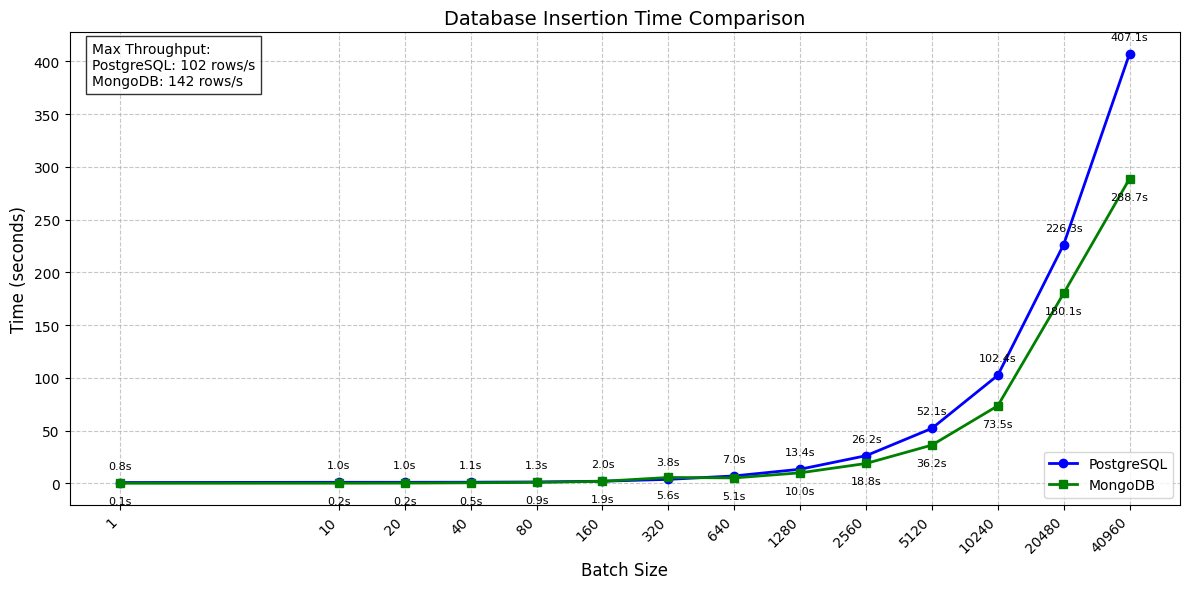

In [237]:
plot_combined_insertion_metrics(postgres_metrics, mongo_metrics)

### 2. Benchmarking Semantic Search with PostgreSQL and PgVector

In [44]:
import time
import concurrent.futures
import random
from concurrent.futures import ThreadPoolExecutor
from statistics import mean, stdev
import psycopg
from pgvector.psycopg import register_vector

def benchmark_search_postgres(
    connection,
    search_fn,
    result_key,
    database_type="PostgreSQL",
    num_queries=100,
    concurrent_queries=[1, 10, 50, 100],
):
    """
    Benchmark PostgreSQL search performance (vector or hybrid) with concurrent queries.

    Args:
        connection: Database connection.
        search_fn: The search function to benchmark.
        result_key: Key for storing results ('vector' or 'hybrid').
        database_type: Type of database (default 'PostgreSQL').
        num_queries: Number of benchmark iterations.
        concurrent_queries: List of concurrency levels to test.
    """
    query_templates = [
        "When was YouTube officially launched, and by whom?",
        "What is YouTube's slogan introduced after Google's acquisition?",
        "How many hours of videos are collectively watched on YouTube daily?",
        "Which was the first video uploaded to YouTube, and when was it uploaded?",
        "What was the acquisition cost of YouTube by Google, and when was the deal finalized?",
        "What was the first YouTube video to reach one million views, and when did it happen?",
        "What are the three separate branches of the United States government?",
        "Which country has the highest documented incarceration rate and prison population?",
        "How many executions have occurred in the United States since 1977, and which countries have more?",
        "What percentage of the global military spending did the United States account for in 2019?",
        "How is the U.S. president elected?",
        "What cooling system innovation was included in the proposed venues for the World Cup in Qatar?",
        "What lawsuit was filed against Google in June 2020, and what was it about?",
        "How much was Google fined by CNIL in January 2022, and for what reason?",
        "When did YouTube join the NSA's PRISM program, according to reports?",
    ]

    # Initialize results structure if not already present.
    if database_type not in benchmark_results:
        benchmark_results[database_type] = {}
    benchmark_results[database_type][result_key] = {}
    benchmark_results[database_type][result_key]["specific"] = {}

    def execute_single_query():
        """Execute a single query and measure its latency."""
        query = random.choice(query_templates)
        start_time = time.time()
        # Call the passed-in search function
        search_fn(query, connection, top_n=5)
        end_time = time.time()
        return end_time - start_time

    # Run the benchmark for each concurrency level.
    for number_of_queries in concurrent_queries:
        latencies = []
        for _ in range(num_queries):
            with ThreadPoolExecutor(max_workers=number_of_queries) as executor:
                # Submit queries concurrently and collect latencies.
                futures = [executor.submit(execute_single_query) for _ in range(number_of_queries)]
                batch_latencies = [future.result() for future in concurrent.futures.as_completed(futures)]
                latencies.extend(batch_latencies)

        avg_latency = mean(latencies)
        throughput = 1 / avg_latency  # Base queries per second per query.
        p95_latency = sorted(latencies)[int(len(latencies) * 0.95)]
        std_dev_latency = stdev(latencies)

        benchmark_results[database_type][result_key]["specific"][number_of_queries] = {
            "avg_latency": avg_latency,
            "throughput": throughput * number_of_queries,  # Scale throughput by concurrency.
            "p95_latency": p95_latency,
            "std_dev": std_dev_latency,
        }

    return benchmark_results


In [45]:
CONCURRENT_QUERIES = [1, 2, 4, 5, 8]

In [46]:
# Run the benchmark
try:
    conn = psycopg.connect(
        f"dbname={neon_db_database} user={neon_db_user} password={neon_db_password} host={neon_db_host}"
    )
    register_vector(conn)

    print("Running performance analysis for vector search...")
    # Run the performance analysis for vector and hybrid search
    benchmark_search_postgres(conn, 
                              vector_search_with_postgres, 
                              "vector", 
                              database_type="PostgreSQL", 
                              num_queries=TOTAL_QUERIES, 
                              concurrent_queries=CONCURRENT_QUERIES)
    
    print("Running performance analysis for hybrid search...")
    benchmark_search_postgres(conn, 
                              hybrid_search_with_postgres, 
                              "hybrid",
                              database_type="PostgreSQL",
                              num_queries=TOTAL_QUERIES,
                              concurrent_queries=CONCURRENT_QUERIES)

except Exception as e:
    print("Benchmark failed:", e)
finally:
    conn.close()
    print("\nConnection closed")

Running performance analysis for vector search...
Running performance analysis for hybrid search...

Connection closed


#### 2.1 PostgreSQL Semantic Search Benchmark

In [123]:
# import concurrent.futures
# import random
# from concurrent.futures import ThreadPoolExecutor
# from statistics import mean, stdev

# import psycopg
# from pgvector.psycopg import register_vector


# def benchmark_semantic_search_postgres(
#     connection,
#     database_type="PostgreSQL",
#     num_queries=100,
#     concurrent_queries=[1, 10, 50, 100],
# ):
#     """
#     Benchmark the vector database performance with true concurrent queries.

#     Args:
#         connection: Database connection
#         database_type: Type of database (e.g., 'PostgreSQL', 'MongoDB')
#         num_queries: Number of benchmark iterations for statistical significance
#         concurrent_queries: Different concurrency levels to test
#     """
#     query_templates = [
#         "When was YouTube officially launched, and by whom?",
#         "What is YouTube's slogan introduced after Google's acquisition?",
#         "How many hours of videos are collectively watched on YouTube daily?",
#         "Which was the first video uploaded to YouTube, and when was it uploaded?",
#         "What was the acquisition cost of YouTube by Google, and when was the deal finalized?",
#         "What was the first YouTube video to reach one million views, and when did it happen?",
#         "What are the three separate branches of the United States government?",
#         "Which country has the highest documented incarceration rate and prison population?",
#         "How many executions have occurred in the United States since 1977, and which countries have more?",
#         "What percentage of the global military spending did the United States account for in 2019?",
#         "How is the U.S. president elected?",
#         "What cooling system innovation was included in the proposed venues for the World Cup in Qatar?",
#         "What lawsuit was filed against Google in June 2020, and what was it about?",
#         "How much was Google fined by CNIL in January 2022, and for what reason?",
#         "When did YouTube join the NSA's PRISM program, according to reports?",
#     ]

#     if database_type not in benchmark_results:
#         benchmark_results[database_type] = {}
        
#     benchmark_results[database_type]["vector"] = {}
#     benchmark_results[database_type]["vector"]["specific"] = {}

#     def execute_single_query():
#         """Execute a single query and measure its latency"""
#         query = random.choice(query_templates)
#         start_time = time.time()
#         result = vector_search_with_postgres(query, connection, top_n=5)
#         end_time = time.time()
#         return end_time - start_time

#     for number_of_queries in concurrent_queries:
#         latencies = []

#         for _ in range(num_queries):
#             with ThreadPoolExecutor(max_workers=number_of_queries) as executor:
#                 # Submit queries and get individual latencies
#                 futures = [
#                     executor.submit(execute_single_query)
#                     for _ in range(number_of_queries)
#                 ]
#                 # Collect individual query latencies as they complete
#                 batch_latencies = [
#                     future.result()
#                     for future in concurrent.futures.as_completed(futures)
#                 ]
#                 latencies.extend(batch_latencies)

#         # Calculate metrics using individual query latencies
#         avg_latency = mean(latencies)
#         throughput = 1 / avg_latency  # Base queries per second per query
#         p95_latency = sorted(latencies)[int(len(latencies) * 0.95)]
#         std_dev_latency = stdev(latencies)

#         benchmark_results[database_type]["vector"]["specific"][number_of_queries] = {
#             "avg_latency": avg_latency,
#             "throughput": throughput * number_of_queries,  # Scale by concurrent queries
#             "p95_latency": p95_latency,
#             "std_dev": std_dev_latency,
#         }

#     return benchmark_results

In [124]:
# def benchmark_hybrid_search_postgres(
#     connection,
#     database_type="PostgreSQL",
#     num_queries=100,
#     concurrent_queries=[1, 10, 50, 100],
# ):
#     """
#     Benchmark the vector database performance with true concurrent queries.

#     Args:
#         connection: Database connection
#         database_type: Type of database (e.g., 'PostgreSQL', 'MongoDB')
#         num_queries: Number of benchmark iterations for statistical significance
#         concurrent_queries: Different concurrency levels to test
#     """
#     query_templates = [
#         "When was YouTube officially launched, and by whom?",
#         "What is YouTube's slogan introduced after Google's acquisition?",
#         "How many hours of videos are collectively watched on YouTube daily?",
#         "Which was the first video uploaded to YouTube, and when was it uploaded?",
#         "What was the acquisition cost of YouTube by Google, and when was the deal finalized?",
#         "What was the first YouTube video to reach one million views, and when did it happen?",
#         "What are the three separate branches of the United States government?",
#         "Which country has the highest documented incarceration rate and prison population?",
#         "How many executions have occurred in the United States since 1977, and which countries have more?",
#         "What percentage of the global military spending did the United States account for in 2019?",
#         "How is the U.S. president elected?",
#         "What cooling system innovation was included in the proposed venues for the World Cup in Qatar?",
#         "What lawsuit was filed against Google in June 2020, and what was it about?",
#         "How much was Google fined by CNIL in January 2022, and for what reason?",
#         "When did YouTube join the NSA's PRISM program, according to reports?",
#     ]

#     if database_type not in benchmark_results:
#         benchmark_results[database_type] = {}

#     benchmark_results[database_type]["hybrid"] = {}
#     benchmark_results[database_type]["hybrid"]["specific"] = {}

#     def execute_single_query():
#         """Execute a single query and measure its latency"""
#         query = random.choice(query_templates)
#         start_time = time.time()
#         result = hybrid_search_with_postgres(query, connection, top_n=5)
#         end_time = time.time()
#         return end_time - start_time

#     for number_of_queries in concurrent_queries:
#         latencies = []

#         for _ in range(num_queries):
#             with ThreadPoolExecutor(max_workers=number_of_queries) as executor:
#                 # Submit queries and get individual latencies
#                 futures = [
#                     executor.submit(execute_single_query)
#                     for _ in range(number_of_queries)
#                 ]
#                 # Collect individual query latencies as they complete
#                 batch_latencies = [
#                     future.result()
#                     for future in concurrent.futures.as_completed(futures)
#                 ]
#                 latencies.extend(batch_latencies)

#         # Calculate metrics using individual query latencies
#         avg_latency = mean(latencies)
#         throughput = 1 / avg_latency  # Base queries per second per query
#         p95_latency = sorted(latencies)[int(len(latencies) * 0.95)]
#         std_dev_latency = stdev(latencies)

#         benchmark_results[database_type]["hybrid"]["specific"][number_of_queries] = {
#             "avg_latency": avg_latency,
#             "throughput": throughput * number_of_queries,  # Scale by concurrent queries
#             "p95_latency": p95_latency,
#             "std_dev": std_dev_latency,
#         }

#     return benchmark_results

In [126]:
# # Run the benchmark
# try:
#     conn = psycopg.connect(
#         f"dbname={neon_db_database} user={neon_db_user} password={neon_db_password} host={neon_db_host}"
#     )
#     register_vector(conn)

#     print("Running benchmark...")
#     results = benchmark_semantic_search_postgres(
#         conn,
#         database_type="PostgreSQL",
#         num_queries=TOTAL_QUERIES,
#         concurrent_queries=CONCURRENT_QUERIES,
#     )

# except Exception as e:
#     print("Benchmark failed:", e)
# finally:
#     conn.close()
#     print("\nConnection closed")

Running benchmark...

Connection closed


In [127]:
# # Run the benchmark
# try:
#     conn = psycopg.connect(
#         f"dbname={neon_db_database} user={neon_db_user} password={neon_db_password} host={neon_db_host}"
#     )
#     register_vector(conn)

#     print("Running benchmark...")
#     results = benchmark_hybrid_search_postgres(
#         conn,
#         database_type="PostgreSQL",
#         num_queries=TOTAL_QUERIES,
#         concurrent_queries=CONCURRENT_QUERIES,
#     )

# except Exception as e:
#     print("Benchmark failed:", e)
# finally:
#     conn.close()
#     print("\nConnection closed")

Running benchmark...

Connection closed


In [47]:
import pprint

pprint.pprint(benchmark_results["PostgreSQL"])

{'hybrid': {'specific': {1: {'avg_latency': 0.8116331028938294,
                             'p95_latency': 0.8516368865966797,
                             'std_dev': 0.03839433226690493,
                             'throughput': 1.23208380293332},
                         2: {'avg_latency': 1.4089710330963134,
                             'p95_latency': 1.658116102218628,
                             'std_dev': 0.17132999857100933,
                             'throughput': 1.4194755981639016},
                         4: {'avg_latency': 2.459243887066841,
                             'p95_latency': 3.079578161239624,
                             'std_dev': 0.4270663842610935,
                             'throughput': 1.6265161910276538},
                         5: {'avg_latency': 2.9366188616752624,
                             'p95_latency': 3.647641181945801,
                             'std_dev': 0.4964712065994472,
                             'throughput': 1.702638386360984

#### 2.2 MongoDB Semantic Search Benchmark

In [48]:
def benchmark_search_mongo(
    collection,
    search_fn,
    result_key,
    database_type="MongoDB",
    num_queries=100,
    concurrent_queries=[1, 10, 50, 100],
):
    """
    Benchmark MongoDB search performance (vector or hybrid) with true concurrency.

    Args:
        collection: MongoDB collection object.
        search_fn: The search function to benchmark. It should accept a query string.
                   For example:
                     - For vector search: lambda q: vector_search_with_mongodb(q, collection, top_n=5)
                     - For hybrid search: lambda q: hybrid_search_with_mongodb(collection, q)
        result_key: Key to store results under (e.g., "vector" or "hybrid").
        database_type: Type of database (default: "MongoDB").
        num_queries: Number of benchmark iterations for statistical significance.
        concurrent_queries: Different concurrency levels to test.
        
    Returns:
        The updated benchmark results for the specified database type.
    """
    query_templates = [
        "When was YouTube officially launched, and by whom?",
        "What is YouTube's slogan introduced after Google's acquisition?",
        "How many hours of videos are collectively watched on YouTube daily?",
        "Which was the first video uploaded to YouTube, and when was it uploaded?",
        "What was the acquisition cost of YouTube by Google, and when was the deal finalized?",
        "What was the first YouTube video to reach one million views, and when did it happen?",
        "What are the three separate branches of the United States government?",
        "Which country has the highest documented incarceration rate and prison population?",
        "How many executions have occurred in the United States since 1977, and which countries have more?",
        "What percentage of the global military spending did the United States account for in 2019?",
        "How is the U.S. president elected?",
        "What cooling system innovation was included in the proposed venues for the World Cup in Qatar?",
        "What lawsuit was filed against Google in June 2020, and what was it about?",
        "How much was Google fined by CNIL in January 2022, and for what reason?",
        "When did YouTube join the NSA's PRISM program, according to reports?",
    ]

    if database_type not in benchmark_results:
        benchmark_results[database_type] = {}
    benchmark_results[database_type][result_key] = {}
    benchmark_results[database_type][result_key]["specific"] = {}

    def execute_single_query():
        """Execute a single query using the provided search function and measure its latency."""
        query = random.choice(query_templates)
        start_time = time.time()
        # The search_fn is expected to handle the query and perform the search
        result = search_fn(query, collection)
        end_time = time.time()
        return end_time - start_time

    # Loop over each concurrency level and accumulate latencies.
    for number_of_queries in concurrent_queries:
        latencies = []
        for _ in range(num_queries):
            with ThreadPoolExecutor(max_workers=number_of_queries) as executor:
                # Submit multiple queries concurrently.
                futures = [
                    executor.submit(execute_single_query)
                    for _ in range(number_of_queries)
                ]
                # Collect latencies as queries complete.
                batch_latencies = [
                    future.result()
                    for future in concurrent.futures.as_completed(futures)
                ]
                latencies.extend(batch_latencies)

        # Calculate benchmark metrics.
        avg_latency = mean(latencies)
        throughput = 1 / avg_latency  # Base queries per second per query.
        p95_latency = sorted(latencies)[int(len(latencies) * 0.95)]
        std_dev_latency = stdev(latencies)

        benchmark_results[database_type][result_key]["specific"][number_of_queries] = {
            "avg_latency": avg_latency,
            "throughput": throughput * number_of_queries,  # Scale throughput by concurrency.
            "p95_latency": p95_latency,
            "std_dev": std_dev_latency,
        }

    return benchmark_results[database_type]


In [49]:
# Run the benchmark for MongoDB
try:
    mongo_client = get_mongo_client(MONGO_URI)
    db = mongo_client[DB_NAME]
    collection = db[COLLECTION_NAME]

    print("Running MongoDB benchmark vector search...")
    benchmark_search_mongo(
        collection,
        search_fn=vector_search_with_mongodb,
        result_key="vector",
        num_queries=TOTAL_QUERIES, 
        concurrent_queries=CONCURRENT_QUERIES
    )

    print("Running MongoDB benchmark hybrid search...")
    benchmark_search_mongo(
        collection,
        search_fn=hybrid_search_with_mongodb,
        result_key="hybrid",
        num_queries=TOTAL_QUERIES,
        concurrent_queries=CONCURRENT_QUERIES
    )

except Exception as e:
    print("MongoDB benchmark failed:", e)
finally:
    mongo_client.close()
    print("\nMongoDB connection closed")

Connection to MongoDB successful
Running MongoDB benchmark vector search...
Running MongoDB benchmark hybrid search...

MongoDB connection closed


In [50]:
print(benchmark_results)

{'PostgreSQL': {'insert_time': {'total_time': 1047.128504037857, 'rows_per_second': 95.49926261618094, 'total_rows': 100000}, 'vector': {'specific': {1: {'avg_latency': 0.563868145942688, 'throughput': 1.7734642525836897, 'p95_latency': 0.6186208724975586, 'std_dev': 0.029588421226714217}, 2: {'avg_latency': 0.9165281581878663, 'throughput': 2.182147904712872, 'p95_latency': 1.298844814300537, 'std_dev': 0.22021277157616406}, 4: {'avg_latency': 1.9367144322395324, 'throughput': 2.065353535562067, 'p95_latency': 2.8457531929016113, 'std_dev': 0.6207439243460737}, 5: {'avg_latency': 2.337306119441986, 'throughput': 2.139214867239432, 'p95_latency': 3.448301076889038, 'std_dev': 0.7859182881223393}, 8: {'avg_latency': 3.5729210966825486, 'throughput': 2.239064279205042, 'p95_latency': 5.350273847579956, 'std_dev': 1.2362316685981427}}}, 'hybrid': {'specific': {1: {'avg_latency': 0.8116331028938294, 'throughput': 1.23208380293332, 'p95_latency': 0.8516368865966797, 'std_dev': 0.03839433226

#### 2.3 Visualize Vector Search Benchmark

In [53]:
def bar_chart_benchmark_comparison(
    benchmark_results, metric="avg_latency", metric_label="Average Latency (ms)"
):
    """
    Generates bar charts to compare benchmark results for each metric across databases,
    for each search type ("vector" and "hybrid") using the 'specific' results.
    """
    search_types = ["vector", "hybrid"]
    batch_sizes = sorted(list(next(iter(benchmark_results.values()))["vector"]["specific"].keys()))
    
    # Loop over each search type
    for search_type in search_types:
        # Build data for this search type
        data = []
        for batch_size in batch_sizes:
            row = {"Batch Size": batch_size}
            for db_type in benchmark_results:
                try:
                    value = (
                        benchmark_results[db_type]
                        .get(search_type, {})
                        .get("specific", {})
                        .get(batch_size, {})
                        .get(metric, 0)
                    )
                    # If metric is a latency, convert to ms
                    if value is not None and metric in ["avg_latency", "p95_latency"]:
                        value *= 1000  # Convert seconds to ms
                    row[db_type] = value if value is not None else 0
                except Exception:
                    row[db_type] = 0
            data.append(row)
        
        # Prepare labels and values from the data
        labels = [str(row["Batch Size"]) for row in data]
        postgres_values = [row.get("PostgreSQL", 0) for row in data]
        mongodb_values = [row.get("MongoDB", 0) for row in data]
        
        # Create the bar chart for this search type
        fig, ax = plt.subplots(figsize=(15, 6))
        width = 0.35
        x = np.arange(len(labels))
        
        postgres_bars = ax.bar(
            x - width / 2,
            postgres_values,
            width,
            label="PostgreSQL",
            color="lightblue",
            edgecolor="blue",
        )
        mongodb_bars = ax.bar(
            x + width / 2,
            mongodb_values,
            width,
            label="MongoDB",
            color="lightgreen",
            edgecolor="green",
        )
        
        ax.grid(True, linestyle="--", alpha=0.7, axis="y")
        ax.set_title(
            f"{metric_label} Comparison for {search_type.capitalize()} Search", pad=20
        )
        ax.set_xlabel("Concurrent Queries", labelpad=10)
        ax.set_ylabel(metric_label, labelpad=10)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.legend(fontsize=10)
        
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                if height > 0:
                    ax.annotate(
                        f"{height:.2f}",
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha="center",
                        va="bottom",
                        rotation=90,
                        fontsize=8,
                    )
        
        autolabel(postgres_bars)
        autolabel(mongodb_bars)
        
        plt.tight_layout()
        plt.show()

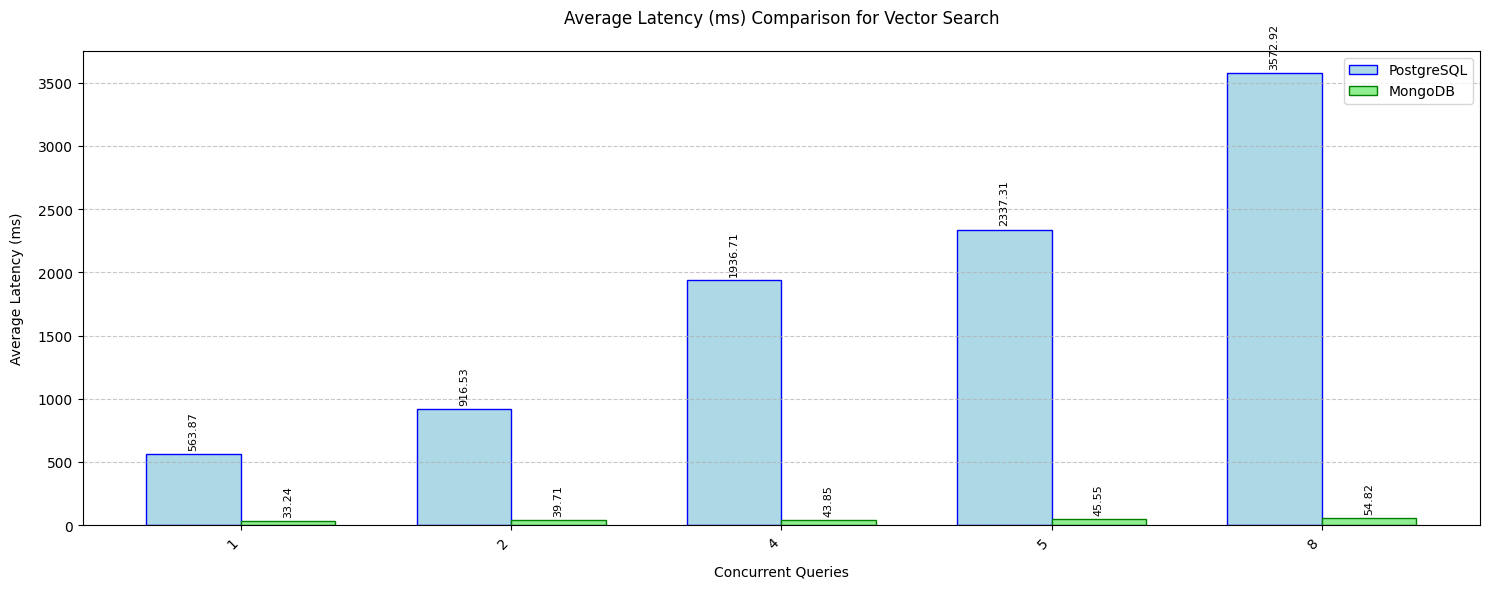

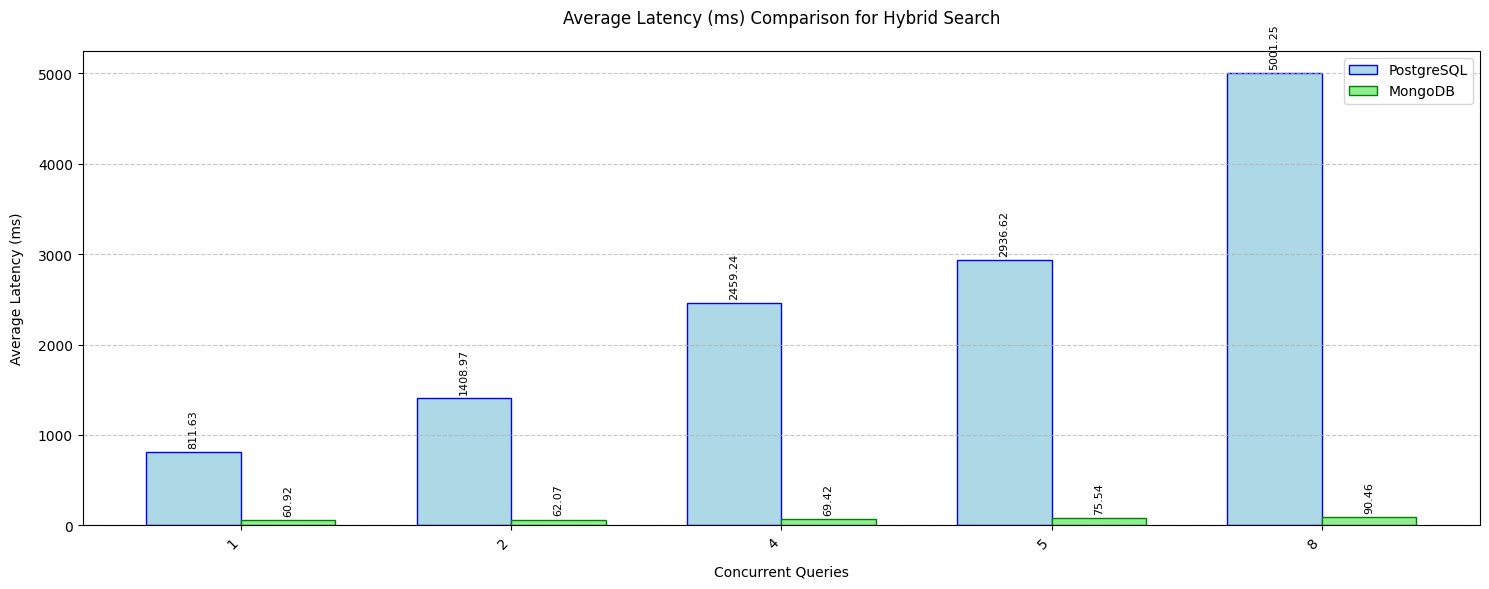

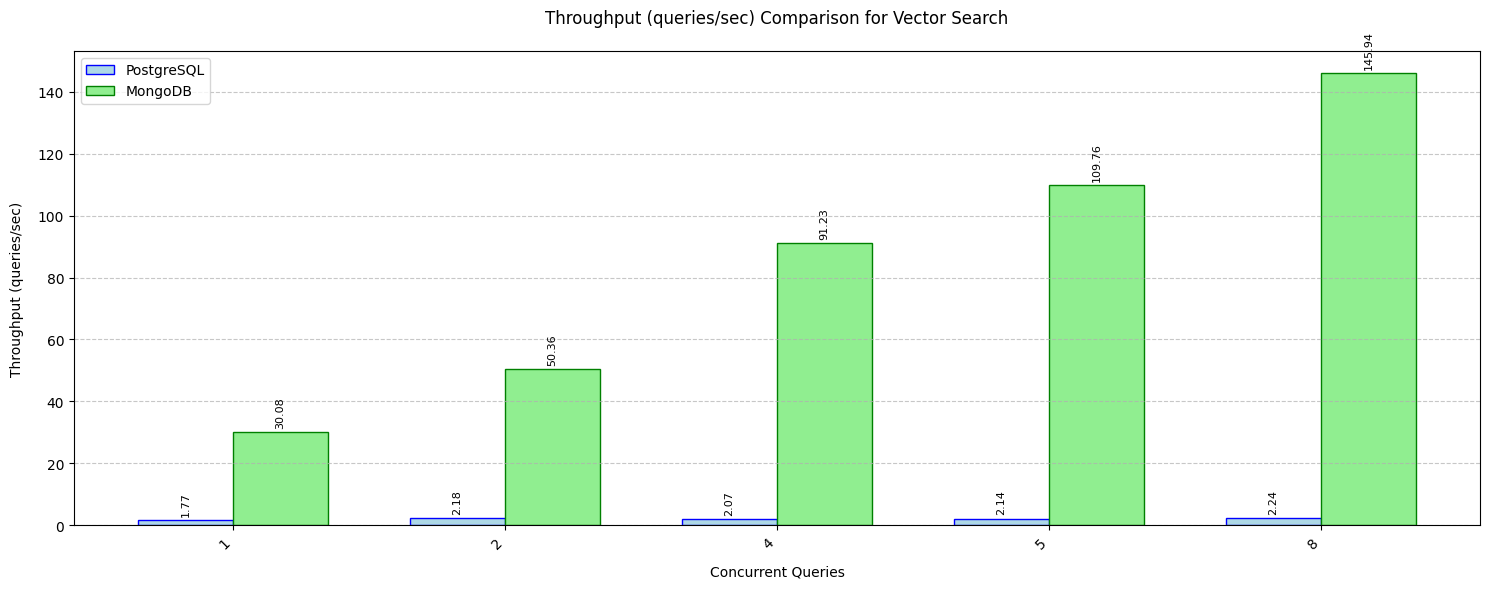

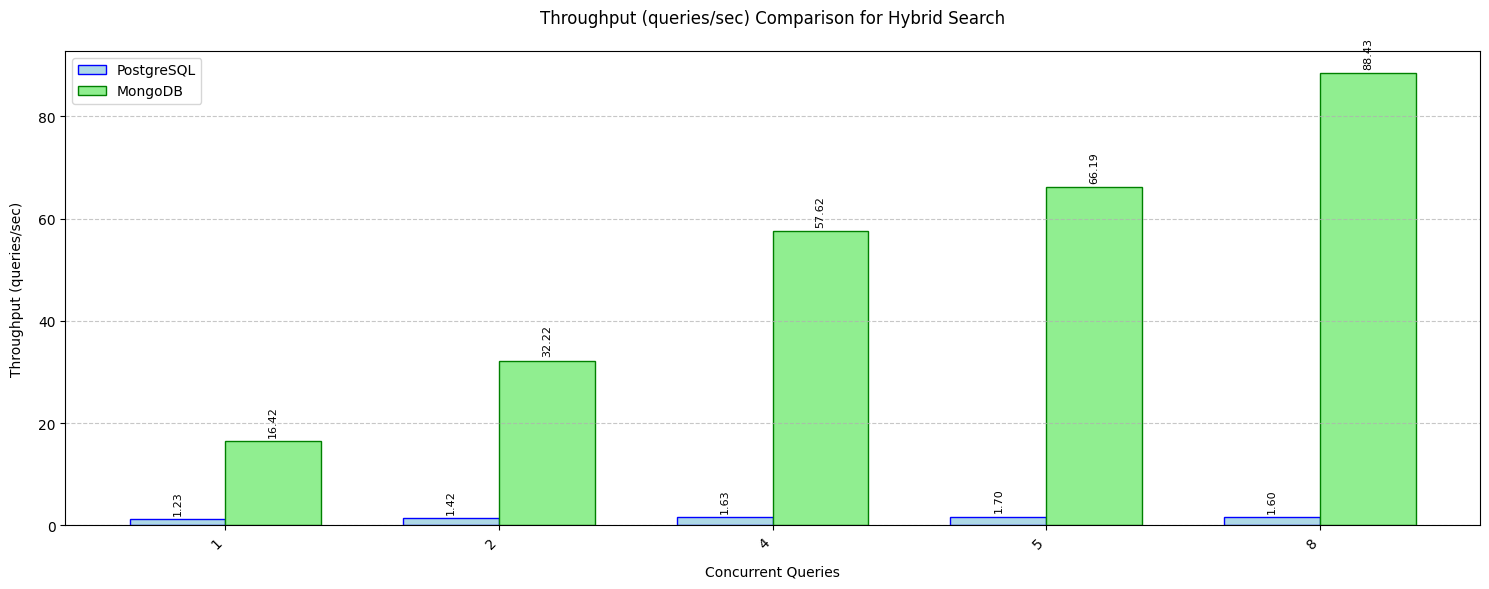

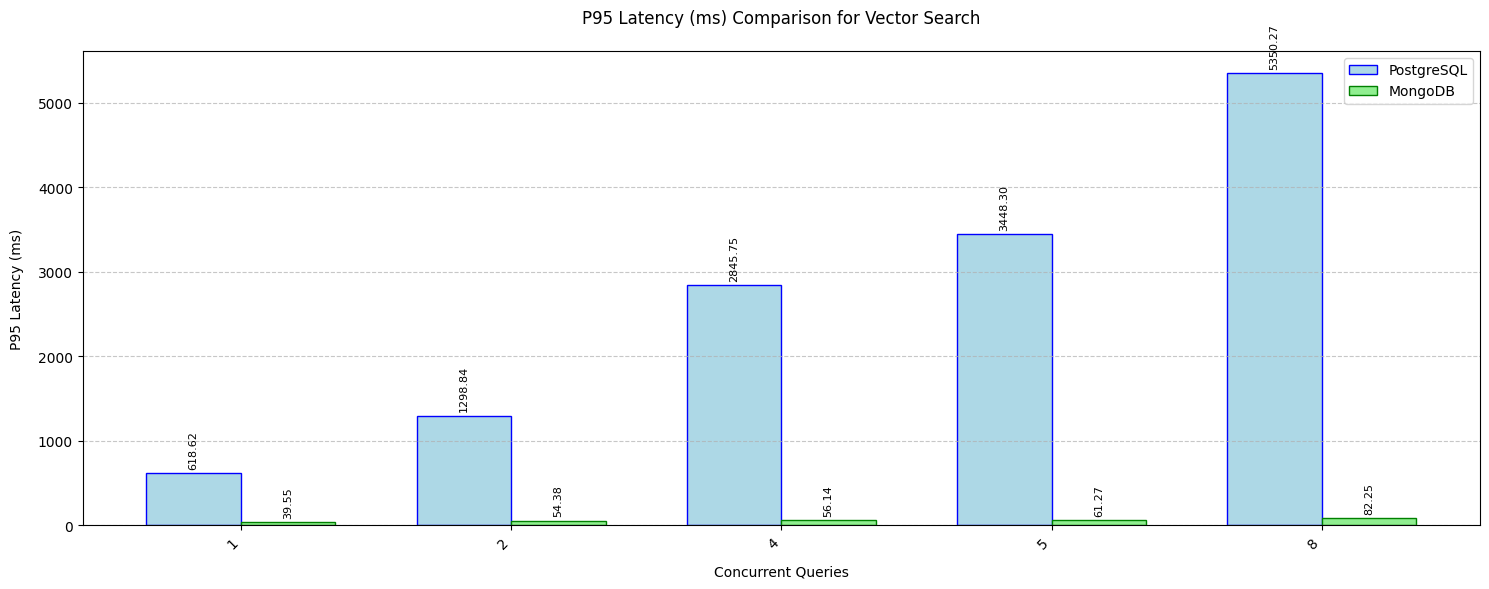

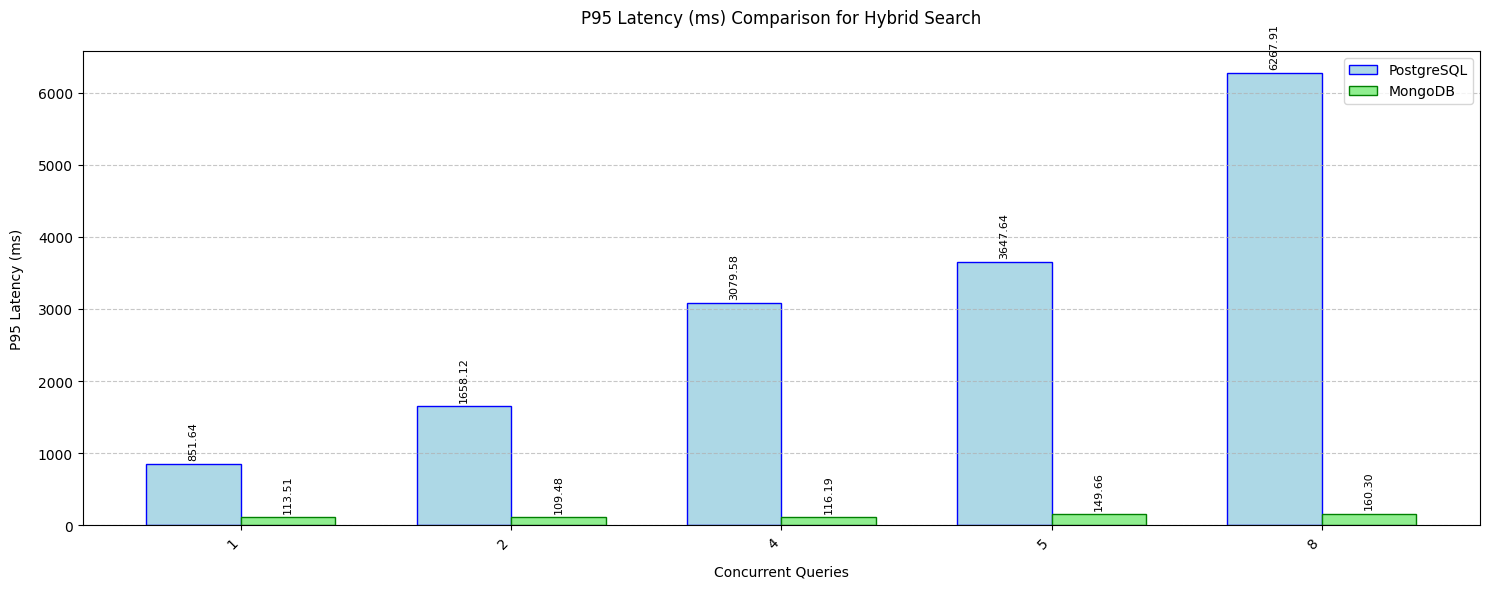

In [54]:
# Generate bar charts for each metric
bar_chart_benchmark_comparison(
    benchmark_results, metric="avg_latency", metric_label="Average Latency (ms)"
)
bar_chart_benchmark_comparison(
    benchmark_results, metric="throughput", metric_label="Throughput (queries/sec)"
)
bar_chart_benchmark_comparison(
    benchmark_results, metric="p95_latency", metric_label="P95 Latency (ms)"
)

## Part 5: Extra Notes


### 5.1 PostgreSQL JSONB vs MongoDB BSON

| Feature                    | **PostgreSQL JSONB**                              | **MongoDB BSON**                              |
|----------------------------|--------------------------------------------------|----------------------------------------------|
| **Integration**            | An extension to a relational database system.    | Native to MongoDB, a document database.      |
| **Query Language**         | Uses SQL with JSONB-specific operators/functions. | Uses MongoDB Query Language (MQL), a JSON-like query syntax. |
| **Storage Optimization**   | Optimized for relational data alongside JSONB.   | Fully optimized for JSON-like document storage. |
| **Data Type Support**      | Stores standard JSON data types (e.g., strings, numbers). | Includes additional types not in standard JSON (e.g., `Date`, `ObjectId`, `Binary`). |
| **Use Case**               | Best for hybrid relational/JSON use cases.       | Designed for flexible schemas, document-based databases. |
| **Updates**                | JSONB supports in-place updates for specific keys or paths. | BSON supports in-place updates with more native support for field-level atomic operations. |
| **Size Overhead**          | Slightly more compact than BSON in some cases.   | Includes metadata like type information, leading to slightly larger size. |


### 5.2 Limitations of pgvector for Handling Large-Dimensional Embeddings

While pgvector is a powerful tool for storing and searching vector embeddings in PostgreSQL, it does have inherent limitations when it comes to handling very high-dimensional embeddings. Here are the key points and [source](https://github.com/pgvector/pgvector/issues/461):

- **PostgreSQL Page Size Constraint:**  
  - **Reason:** PostgreSQL uses fixed 8KB pages for data storage.  
  - **Impact:** Each 32-bit float occupies 4 bytes, so storing a vector with many dimensions quickly exhausts the available space on a page.  
  - **Practical Limit:** This design limits indexed vectors to around 2000 dimensions unless alternative approaches (such as quantization or splitting the vector) are used.

- **Index Tuple Size Limit:**  
  - **Reason:** Even if the underlying table supports larger vectors (up to 16,000 dimensions), the index tuples themselves are constrained by the 8KB limit.  
  - **Impact:** Attempting to build an index on vectors exceeding this limit results in errors or performance degradation.

- **Trade-offs in Workarounds:**  
  - **Quantization:** Converting vectors from 32-bit floats to lower precision (e.g., half-precision) can allow for more dimensions but may reduce accuracy.  
  - **Splitting Vectors:** Dividing a high-dimensional vector across multiple columns or rows increases complexity in reconstructing the original vector for search and may affect retrieval speed.
  - **Alternative Data Types:** Some projects (like pgvecto.rs) bypass these limitations by handling indexing outside PostgreSQL, but this sacrifices the ACID guarantees that pgvector provides.

- **Implications for AI Workloads:**  
  - **Model Compatibility:** Many modern embedding models (e.g., OpenAI’s `text-embedding-3-large` with 3072 dimensions) produce embeddings that exceed pgvector’s optimal indexed dimension size, potentially forcing truncation or quantization.
  - **Search Quality:** These workarounds (truncation, quantization, or splitting) can impact the precision and recall of similarity searches—a critical factor for many AI applications.


### 5.3 Workaround Options for High-Dimensional Embeddings in pgvector

The pgvector project has received several suggestions and workaround proposals to mitigate the limitation of indexing high-dimensional vectors (beyond ~2000 dimensions). Two key comments from issues [#326](https://github.com/pgvector/pgvector/issues/326#issuecomment-2024106976) and [#395](https://github.com/pgvector/pgvector/issues/395#issuecomment-2024089498) detail some of these options.

---

#### 5.3.1 Option 1: Use Lower Precision with `halfvec`

- **Description:**  
  Convert full-precision (fp32) vectors to half-precision (fp16) for indexing purposes.
  
- **How It Works:**  
  - **Storage:** Vectors are stored as `vector(n)` (still in fp32) in the table.
  - **Indexing:** When creating the index, the vector is cast to the `halfvec` type (fp16) using syntax like:
    ```sql
    CREATE INDEX ON items USING hnsw ((embedding::halfvec(n)) halfvec_l2_ops);
    ```
  
- **Benefits:**  
  - **Smaller Index Size:** fp16 values require half the storage of fp32, which can allow more dimensions to fit within the 8KB index tuple limit.
  - **Faster Index Build:** Smaller data size can lead to quicker index creation.
  
- **Trade-offs:**  
  - **Loss of Precision:** Quantizing from 32-bit to 16-bit floats introduces rounding errors.  
  - **Impact on Recall:** Testing has shown that recall remains nearly identical in many cases, but the loss in precision may not be acceptable for all applications.

- **Appropriateness:**  
  This workaround is appropriate if the application can tolerate a slight reduction in numerical precision without significantly affecting the quality of similarity search results.

---

#### 5.3.2 Option 2: Split the Embedding Across Multiple Rows or Columns

- **Description:**  
  Divide a high-dimensional vector into multiple smaller vectors that can be stored and indexed separately.
  
- **How It Works:**  
  - **Schema Change:** Instead of storing one vector with dimensions greater than the limit, split it into two or more parts (e.g., a 3072-dimensional vector into one part of 2000 dimensions and another of 1072 dimensions).
  - **Indexing:** Build separate indexes for each part and then combine the results (possibly with a re-ranking step) during query time.
  
- **Benefits:**  
  - **Full Precision Retained:** No need to quantize the data, so the original accuracy is preserved.
  - **Scalability:** This approach can support arbitrarily high dimensions by splitting the data.
  
- **Trade-offs:**  
  - **Complexity:** Requires changes to the schema and additional logic in query processing to recombine or re-rank partial results.
  - **Performance Overhead:** Merging results from multiple indexes can add latency to the search process.

- **Appropriateness:**  
  This workaround is most appropriate when high precision is critical and the application cannot afford any loss in accuracy. It adds complexity but retains full precision for each vector.
